# Group 6 - Project B

## Contents:
### 1. Libraries & Functions
### 2. Main Program and Neural Network Architecture
### 3. Checking the model with Experimental (Cross-Validation) and Numerical Data (Training)
### 4. Prediction with Group 6 Data
### 5. Weighted Average Ensemble
### 6. Regression Analysis with Machine Learning Algorithms
### 7. Hyper-Parameter Tuning

# 1. Libraries & Functions

In [122]:
# Importing required Libraries:

import pandas as pd
import numpy as np
from numpy import newaxis
import glob
import re
import scipy
import scipy.io as sio
from scipy import signal
import os
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import math
from collections import defaultdict
import openpyxl

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [123]:
pwd

'C:\\Users\\Vaishnav Bhaskaran\\CIE\\exercise_cie\\Project_B'

In [124]:
# Filepath:

fp_num_data = r'C:\Users\Vaishnav Bhaskaran\CIE\exercise_cie\Project_B\Project_B_Data\EPOT_Data'
fp_exp_data = r'C:\Users\Vaishnav Bhaskaran\CIE\exercise_cie\Project_B\Project_B_Data\Experimental_validation\**'
fp_group_6 = r'C:\Users\Vaishnav Bhaskaran\CIE\exercise_cie\Project_B\Group6\Group6'
fp_index = r'C:\Users\Vaishnav Bhaskaran\CIE\exercise_cie\Project_B'

In [125]:
# Creating Lists for Numerical, Experimental and Group 6 Data:

EPOT_data = []
for x in glob.glob(fp_num_data+'/*.mat*'):
    EPOT_data.append(x)
    
exp_data = []
for y in glob.glob(fp_exp_data+'/*.txt*'):
    exp_data.append(y)
    
group6_data = []
for x in glob.glob(fp_group_6+'/*.txt*'):
    group6_data.append(x)

if(glob.glob(fp_index+'/*_Range*')):
    excel = pd.read_excel('Cut_Index_Range.xlsx',skiprows=(0))

In [126]:
# Extracting the Impact location - x & y coordinates:

def get_coordinates(data,x):
    pattern = r'\d\d\d'
    subject = re.findall(pattern,data)
    x_coord = int(subject[0])
    y_coord = int(subject[1])
    
    return x_coord,y_coord

In [127]:
# Reading file:

def read_file(data,x):
    if (data.endswith('.mat')):
        mat = sio.loadmat(data)
        mat_1 = mat["num_data"]
        mat_2 = mat_1[:,1:]
        mat_norm = sklearn.preprocessing.normalize(mat_2,axis=0)
        mat_3 = mat_norm[newaxis,:,:]

        return(np.concatenate((mat_read,mat_3),axis=0))
    
    elif (data.endswith('.txt')):
        if (coord_exp[x,0]*325 == 250 and coord_exp[x,1]*325 == 260):
            txt = pd.read_csv(data, sep="\t", skiprows=(0,1,2,3,4,5,6), lineterminator='\n', decimal=',')

            txt_1[:,0] = txt['V\r']
            txt_1[:,1] = txt['V.1']
            txt_1[:,2] = txt['V']
            txt_1[:,3] = txt['V.2']
        
        else:
            txt = pd.read_csv(data, sep="\t", skiprows=(0,1,2,3,4,5,6), lineterminator='\n', decimal=',')

            txt_1[:,0] = txt['V']
            txt_1[:,1] = txt['V.1']
            txt_1[:,2] = txt['V\r']
            txt_1[:,3] = txt['V.2']
            
    return (txt_1)

In [128]:
def get_index(data):
    file_name = data.split('\\')[-1]
    file_name = file_name.split('.')[0]
    file_indices = (excel[excel.iloc[:,0] == file_name])
    
    cut_index[0,:] = [file_indices.iloc[0,1],file_indices.iloc[0,2]]
    cut_index[1,:] = [file_indices.iloc[0,3],file_indices.iloc[0,4]]
    cut_index[2,:] = [file_indices.iloc[0,5],file_indices.iloc[0,6]]
    cut_index[3,:] = [file_indices.iloc[0,7],file_indices.iloc[0,8]]
    
    return (cut_index.astype(int))

In [129]:
# Preprocessing the Data - Cutting and Resampling:

def preprocessing(data,cut_index):
    txt_cut_1 = np.empty((cut_index[0,1]-cut_index[0,0],1))
    txt_cut_2 = np.empty((cut_index[1,1]-cut_index[1,0],1))
    txt_cut_3 = np.empty((cut_index[2,1]-cut_index[2,0],1))
    txt_cut_4 = np.empty((cut_index[3,1]-cut_index[3,0],1))
    
    txt_cut_1 = -data[cut_index[0,0]:cut_index[0,1],0]
    txt_cut_2 = -data[cut_index[1,0]:cut_index[1,1],1]
    txt_cut_3 = -data[cut_index[2,0]:cut_index[2,1],2]
    txt_cut_4 = -data[cut_index[3,0]:cut_index[3,1],3]
    
    txt_re_1 = signal.resample(txt_cut_1,21000)
    txt_re_2 = signal.resample(txt_cut_2,21000)
    txt_re_3 = signal.resample(txt_cut_3,21000)
    txt_re_4 = signal.resample(txt_cut_4,21000)
    
    txt_re = np.concatenate((txt_re_1[:,newaxis],txt_re_2[:,newaxis],txt_re_3[:,newaxis],txt_re_4[:,newaxis]),axis=1)
    txt_norm = sklearn.preprocessing.normalize(txt_re,axis=0)

    return(txt_norm)

In [130]:
# Data Augmentation:
# Sensors P2 and P4 are interchanged. P1 and P3 will remain the same

def augment_Q2(data,coord,x):    
    Q2_dummy[:,:,0] = data[x,:,0]
    Q2_dummy[:,:,1] = data[x,:,3]
    Q2_dummy[:,:,2] = data[x,:,2]
    Q2_dummy[:,:,3] = data[x,:,1]
    
    diff_x = coord[0]-250
    
    Q2_coor[0,0] = coord[0]-2*diff_x
    Q2_coor[0,1] = coord[1]
     
    return(np.concatenate((Q2_aug,Q2_dummy),axis=0),np.concatenate((Q2_coord,Q2_coor),axis=0))

In [131]:
# Data Augmentation:
# Sensors P1-P2 & P3-P4 are interchanged

def augment_Q3(data,coord,x):
    Q3_dummy[:,:,0] = data[x,:,2]
    Q3_dummy[:,:,1] = data[x,:,3]
    Q3_dummy[:,:,2] = data[x,:,0]
    Q3_dummy[:,:,3] = data[x,:,1]
    
    diff_x = coord[0]-250
    diff_y = coord[1]-250
    
    Q3_coor[0,0] = coord[0]-2*diff_x
    Q3_coor[0,1] = coord[1]-2*diff_y
    
    return(np.concatenate((Q3_aug,Q3_dummy),axis=0),np.concatenate((Q3_coord,Q3_coor),axis=0))

In [132]:
# Data Augmentation:
# Sensors P1 and P3 are interchanged. P2 and P4 will remain the same

def augment_Q4(data,coord,x):
    Q4_dummy[:,:,0] = data[x,:,2]
    Q4_dummy[:,:,1] = data[x,:,1]
    Q4_dummy[:,:,2] = data[x,:,0]
    Q4_dummy[:,:,3] = data[x,:,3]
    
    diff_y = coord[1]-250
    
    Q4_coor[0,0] = coord[0]
    Q4_coor[0,1] = coord[1]-2*diff_y
    
    return(np.concatenate((Q4_aug,Q4_dummy),axis=0),np.concatenate((Q4_coord,Q4_coor),axis=0))

In [133]:
# Data Augmentation:
# Impact locations on the X and Y axis have to be augmented only once

def augment_axis(data,coord,x):
    if coord[0] == 250 and coord[1] != 250:
        xy_dummy[:,:,0] = data[x,:,2]
        xy_dummy[:,:,1] = data[x,:,1]
        xy_dummy[:,:,2] = data[x,:,0]
        xy_dummy[:,:,3] = data[x,:,3]
        
        diff_y = coord[1]-250
    
        xy_coor[0,0] = coord[0]
        xy_coor[0,1] = coord[1]-2*diff_y

    return(np.concatenate((xy_aug,xy_dummy),axis=0),np.concatenate((xy_coord,xy_coor),axis=0))

    if coord[1] == 250 and coord[0] != 250:
        xy_dummy[:,:,0] = data[x,:,0]
        xy_dummy[:,:,1] = data[x,:,3]
        xy_dummy[:,:,2] = data[x,:,2]
        xy_dummy[:,:,3] = data[x,:,1]

        diff_x = coord[0]-250

        xy_coor[0,0] = coord[0]-2*diff_x
        xy_coor[0,1] = coord[1]

    return(np.concatenate((xy_aug,xy_dummy),axis=0),np.concatenate((xy_coord,xy_coor),axis=0))

In [153]:
def get_models(trg_data,trg_coord,cv_data,cv_coord,pred_data):
# Model 1:
    wp_model_1 = Sequential([tfl.Flatten(input_shape=(20000,4)),
                                tfl.Dense(units=64, activation='sigmoid'),
                                tfl.Dense(units=64, activation='sigmoid'),
                                tfl.Dropout(0.2),
                                tfl.Dense(units=2,activation='sigmoid')])
    
    wp_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.mse)
    
    wpa_model_history_1 = wp_model_1.fit(x=trg_data,y=trg_coord,batch_size=8,epochs=20,shuffle=True,verbose=1,
                                          validation_data=(cv_data,cv_coord))
    
    yhat_1 = (wp_model_1.predict(pred_data))

####-------------------------------------------------------------------------------------------------------------------####

# Model 2:
    wp_model_2 = Sequential([tfl.Flatten(input_shape=(20000,4)),
                                tfl.Dense(units=64, activation='sigmoid'),
                                tfl.Dropout(0.2),
                                tfl.Dense(units=2,activation='sigmoid')])
    
    wp_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.mse)
    
    wpa_model_history_2 = wp_model_2.fit(x=trg_data,y=trg_coord,batch_size=8,epochs=20,shuffle=True,verbose=1,
                                          validation_data=(cv_data,cv_coord))
    
    yhat_2 = (wp_model_2.predict(pred_data))

####-------------------------------------------------------------------------------------------------------------------####

 # Model 3:
    wp_model_3 = Sequential([tfl.Flatten(input_shape=(20000,4)),
                                tfl.Dense(units=64, activation='sigmoid'),
                                tfl.Dense(units=64, activation='sigmoid'),
                                tfl.Dense(units=32, activation='sigmoid'),
                                tfl.Dropout(0.2),
                                tfl.Dense(units=2,activation='sigmoid')])

    wp_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.mse)

    wpa_model_history_3 = wp_model_3.fit(x=trg_data,y=trg_coord,batch_size=4,epochs=20,shuffle=True,verbose=1,
                                          validation_data=(cv_data,cv_coord))
    
    yhat_3 = (wp_model_3.predict(pred_data))
    
    models = [wp_model_1,wp_model_2,wp_model_3]
    yhats = [yhat_1,yhat_2,yhat_3]
    
    return models,yhats

In [154]:
def optimize_weights(yhats):
    df = []
    for w1 in range(0,50,1):
        for w2 in range(0,50,1):
            for w3 in range(0,50,1):
                weights = [w1/100,w2/100,w3/100]
                y_wp = np.tensordot(yhats,weights,axes=((0),(0)))
                mse_wp = mean_squared_error((coord_exp_test*160)+170,(y_wp*160)+170)

                df.append((weights[0],weights[1],weights[2],mse_wp))

    df = pd.DataFrame(df,columns=['weight_1','weight_2','weight_3','mse_wp'])
    min_mse_row = df.iloc[df['mse_wp'].idxmin()]

    print('Individual mse for each model:\n')
    
    for i in range(len(yhats)):
        mse_models = np.empty((len(yhats),1))
        mse_models[i] = mean_squared_error((coord_exp_test*160)+170,(yhats[i]*160)+170)
        print('Model',i+1,'mse:',mse_models[i])

    print('Ensemble mse:\n\nMinimum mse of', min_mse_row[3], 'obtained with weights w1:', min_mse_row[0], ' w2:', min_mse_row[1], ' w3:', min_mse_row[2])

    return (min_mse_row[0:3],df,mse_models)

In [136]:
# Initialising required arays:

mat_read = np.empty((1,20000,4))
cut_index = np.empty((4,2))
txt_read = np.empty((1,20000,4))
group6_read = np.empty((1,20000,4))
txt_1 = np.empty((100001,4))
coord_EPOT = np.empty((len(EPOT_data),2))
coord_exp = np.empty((len(exp_data),2))
Q2_dummy = np.empty((1,20000,4))
Q3_dummy = np.empty((1,20000,4))
Q4_dummy = np.empty((1,20000,4))
xy_dummy = np.empty((1,20000,4))
Q2_aug = np.empty((1,20000,4))
Q3_aug = np.empty((1,20000,4))
Q4_aug = np.empty((1,20000,4))
xy_aug = np.empty((1,20000,4))
Q2_coor = np.empty((1,2))
Q3_coor = np.empty((1,2))
Q4_coor = np.empty((1,2))
xy_coor = np.empty((1,2))
Q2_coord = np.empty((1,2))
Q3_coord = np.empty((1,2))
Q4_coord = np.empty((1,2))
xy_coord = np.empty((1,2))

# 2. Main Program and Neural Network Architecture

In [137]:
# Main Program:

for x in range(len(EPOT_data)):
    mat_read = read_file(EPOT_data[x],x)
    coord_EPOT[x,0],coord_EPOT[x,1] = get_coordinates(EPOT_data[x],x)
    
for x in range(len(exp_data)):
    coord_exp[x,0],coord_exp[x,1] = get_coordinates(exp_data[x],x)
    cut_index = get_index(exp_data[x])
    txt_file = read_file(exp_data[x],x)
    txt_resamp = preprocessing(txt_file,cut_index)
    txt_new = txt_resamp[newaxis,:20000,:]
    txt_read = np.concatenate((txt_read,txt_new),axis=0)

for x in range(len(group6_data)):
    txt_file = read_file(group6_data[x],x)
    txt_resamp = preprocessing(txt_file,cut_index)
    txt_new = txt_resamp[newaxis,:20000,:]
    group6_read = np.concatenate((group6_read,txt_new),axis=0)


mat_df = mat_read[1:,:,:]
txt_df = txt_read[1:,:,:]
group6_df = group6_read[1:,:,:]
coord_exp = (coord_exp-170)/160

In [138]:
# Augmenting the Data to other Quadrants:

for x in range(len(EPOT_data)):
    if coord_EPOT[x,0]!=250 and coord_EPOT[x,1]!=250:
        Q2_aug, Q2_coord = augment_Q2(mat_df,coord_EPOT[x,:],x)
        Q3_aug, Q3_coord = augment_Q3(mat_df,coord_EPOT[x,:],x)
        Q4_aug, Q4_coord = augment_Q4(mat_df,coord_EPOT[x,:],x)
    
    else:
        xy_aug, xy_coord = augment_axis(mat_df,coord_EPOT[x,:],x)

Q2_augmented = Q2_aug[1:,:,:]
Q3_augmented = Q3_aug[1:,:,:]
Q4_augmented = Q4_aug[1:,:,:]
xy_augmented = xy_aug[1:,:,:]

Q2_aug_coord = Q2_coord[1:,:]
Q3_aug_coord = Q3_coord[1:,:]
Q4_aug_coord = Q4_coord[1:,:]
xy_aug_coord = xy_coord[1:,:]

args_mat = [mat_df, Q2_augmented, Q3_augmented, Q4_augmented, xy_augmented]
args_coord = [coord_EPOT, Q2_aug_coord, Q3_aug_coord, Q4_aug_coord, xy_aug_coord]
mat_final = np.concatenate(args_mat, axis=0)
coord_final = np.concatenate(args_coord, axis=0)
coord_final = (coord_final-170)/160

In [139]:
# Neural Network Architecture:

final_model = Sequential([

    tfl.Flatten(input_shape=(20000,4)),
    tfl.Dense(units=64, activation='sigmoid'),
    tfl.Dense(units=64, activation='sigmoid'),
    tfl.Dropout(0.2),
    tfl.Dense(units=2,activation='sigmoid')

    ])

In [140]:
final_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                5120064   
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 130       
Total params: 5,124,354
Trainable params: 5,124,354
Non-trainable params: 0
_________________________________________________________________


# 3. Checking the model with Experimental (Cross-Validation) and Numerical Data (Training)

In [141]:
txt_df_train, txt_df_test, coord_exp_train, coord_exp_test = train_test_split(txt_df, coord_exp, test_size=0.2)


print('Training data shape : ', txt_df_train.shape, coord_exp_train.shape)

print('Testing data shape : ', txt_df_test.shape, coord_exp_test.shape)

Training data shape :  (19, 20000, 4) (19, 2)
Testing data shape :  (5, 20000, 4) (5, 2)


In [142]:
# Training -> Numerical Data
# Cross-Validation -> Experimental Data

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.mse)

fin_model_history_4 = final_model.fit(x=mat_final,y=coord_final,batch_size=8,epochs=20,shuffle=True,verbose=1,
   validation_data=(txt_df_train,coord_exp_train))

Epoch 1/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0884 - val_loss: 0.0324
Epoch 2/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0834 - val_loss: 0.0376
Epoch 3/20
116/116 [==============================] - 3s 24ms/step - loss: 0.0805 - val_loss: 0.0303
Epoch 4/20
116/116 [==============================] - 3s 24ms/step - loss: 0.0756 - val_loss: 0.0248
Epoch 5/20
116/116 [==============================] - 3s 24ms/step - loss: 0.0702 - val_loss: 0.0287
Epoch 6/20
116/116 [==============================] - 3s 28ms/step - loss: 0.0631 - val_loss: 0.0264
Epoch 7/20
116/116 [==============================] - 3s 29ms/step - loss: 0.0573 - val_loss: 0.0187
Epoch 8/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0509 - val_loss: 0.0144
Epoch 9/20
116/116 [==============================] - 3s 25ms/step - loss: 0.0424 - val_loss: 0.0119
Epoch 10/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0359 - val_lo

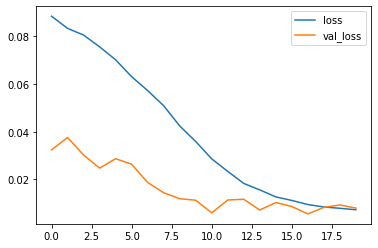

In [143]:
# Loss plots:

plt.plot(fin_model_history_4.history['loss'])
plt.plot(fin_model_history_4.history['val_loss'])
plt.legend(['loss','val_loss'])

In [144]:
# Predicted coordinates:

y_pred_4 = (final_model.predict(txt_df_test))
print('Predicted coordinates:\n',((y_pred_4*160)+170).astype(int))


# Actual coordinates:

print('\nActual coordinates:\n', ((coord_exp_test*160)+170))


# Difference between predicted and actual coordinates:

print('\nDifference between predicted and actual coordinates:\n',(((y_pred_4*160)+170).astype(int) - ((coord_exp_test*160)+170)))
print('\nMean Squared Error:\n',mean_squared_error(((coord_exp_test*160)+170),((y_pred_4*160)+170)))

Predicted coordinates:
 [[244 238]
 [242 236]
 [197 197]
 [315 235]
 [246 242]]

Actual coordinates:
 [[250. 260.]
 [240. 255.]
 [205. 200.]
 [300. 235.]
 [250. 260.]]

Difference between predicted and actual coordinates:
 [[ -6. -22.]
 [  2. -19.]
 [ -8.  -3.]
 [ 15.   0.]
 [ -4. -18.]]

Mean Squared Error:
 147.81220117737539


In [145]:
# Test Set Evaluation:

final_model.evaluate(x=txt_df_test,y=coord_exp_test,batch_size=8,verbose=2)

1/1 - 0s - loss: 0.0058


0.00577391404658556

# 4. Prediction with Group 6 Data

In [146]:
# Training -> Numerical Data
# Cross-Validation -> Experimental Data

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.mse,)

fin_model_history_5 = final_model.fit(x=mat_final,y=coord_final,batch_size=8,epochs=20,shuffle=True,verbose=1,
   validation_data=(txt_df,coord_exp))

Epoch 1/20
116/116 [==============================] - 4s 28ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 2/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 3/20
116/116 [==============================] - 3s 28ms/step - loss: 0.0055 - val_loss: 0.0108
Epoch 4/20
116/116 [==============================] - 3s 28ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 5/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0052 - val_loss: 0.0156
Epoch 6/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 7/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0044 - val_loss: 0.0076
Epoch 8/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0043 - val_loss: 0.0068
Epoch 9/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0041 - val_loss: 0.0127
Epoch 10/20
116/116 [==============================] - 3s 29ms/step - loss: 0.0036 - val_lo

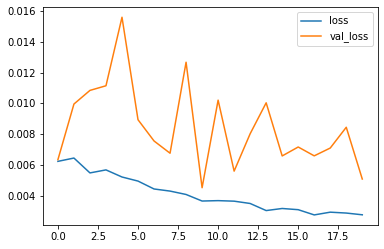

In [147]:
# Loss plots:

plt.plot(fin_model_history_5.history['loss'])
plt.plot(fin_model_history_5.history['val_loss'])
plt.legend(['loss','val_loss'])

In [148]:
# Predicted coordinates:

y_pred_5 = (final_model.predict(group6_df))
print('Predicted coordinates:\n',((y_pred_5*160)+170).astype(int))

Predicted coordinates:
 [[248 245]
 [269 259]
 [239 232]
 [270 246]
 [252 239]
 [266 290]
 [202 213]
 [296 289]
 [232 217]
 [239 247]
 [225 227]
 [214 309]
 [249 228]
 [261 234]
 [255 253]
 [279 282]
 [285 239]
 [229 249]]


# 5. Weighted Average Ensemble

In [155]:
# Compiling and getting predictions of each model in the Ensemble:

models,yhats = get_models(trg_data=mat_final,trg_coord=coord_final,
                          cv_data=txt_df_train,cv_coord=coord_exp_train,
                          pred_data=txt_df_test)

yhats = np.asarray(yhats)

Epoch 1/20
116/116 [==============================] - 5s 37ms/step - loss: 0.0910 - val_loss: 0.0366
Epoch 2/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0807 - val_loss: 0.0334
Epoch 3/20
116/116 [==============================] - 3s 24ms/step - loss: 0.0798 - val_loss: 0.0308
Epoch 4/20
116/116 [==============================] - 3s 29ms/step - loss: 0.0747 - val_loss: 0.0288
Epoch 5/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0692 - val_loss: 0.0263
Epoch 6/20
116/116 [==============================] - 3s 24ms/step - loss: 0.0630 - val_loss: 0.0240
Epoch 7/20
116/116 [==============================] - 3s 25ms/step - loss: 0.0566 - val_loss: 0.0217
Epoch 8/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0492 - val_loss: 0.0147
Epoch 9/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0426 - val_loss: 0.0108
Epoch 10/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0354 - val_lo

In [156]:
# Finding the optimal weights for each model in the Ensemble:

opt_weights,df,mse_models = optimize_weights(yhats)

Individual mse for each model:

Model 1 mse: [254.36489264]
Model 2 mse: [260.51256593]
Model 3 mse: [135.79023661]
Ensemble mse:

Minimum mse of 101.87818619504742 obtained with weights w1: 0.2  w2: 0.31  w3: 0.49


In [157]:
# Predicting for 

ens_models,ens_yhats = get_models(trg_data=mat_final,trg_coord=coord_final,
                                  cv_data=txt_df,cv_coord=coord_exp,
                                  pred_data=group6_df)

Epoch 1/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0951 - val_loss: 0.0324
Epoch 2/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0834 - val_loss: 0.0372
Epoch 3/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0808 - val_loss: 0.0293
Epoch 4/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0746 - val_loss: 0.0288
Epoch 5/20
116/116 [==============================] - 3s 28ms/step - loss: 0.0693 - val_loss: 0.0265
Epoch 6/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0627 - val_loss: 0.0187
Epoch 7/20
116/116 [==============================] - 3s 26ms/step - loss: 0.0573 - val_loss: 0.0156
Epoch 8/20
116/116 [==============================] - 3s 29ms/step - loss: 0.0490 - val_loss: 0.0095
Epoch 9/20
116/116 [==============================] - 3s 27ms/step - loss: 0.0421 - val_loss: 0.0120
Epoch 10/20
116/116 [==============================] - 3s 25ms/step - loss: 0.0350 - val_lo

### Group 6 Data Final Impact Location Final Prediction:

In [158]:
ensemble_pred = np.tensordot(ens_yhats,opt_weights,axes=((0),(0)))
print(((ensemble_pred*160)+170).astype(int))

[[253 240]
 [264 259]
 [253 245]
 [262 245]
 [257 251]
 [256 309]
 [199 232]
 [286 298]
 [219 200]
 [256 249]
 [221 261]
 [230 301]
 [258 234]
 [259 254]
 [250 248]
 [246 287]
 [261 266]
 [249 229]]


# 6. Regression Analysis with Machine Learning Algorithms

# 6.1 Linear Regression

In [80]:
# Extracting Mean Absolute Value of the Signal as feature:

def dim_conversion(X):
    return np.mean(np.abs(X),axis=1)

In [81]:
# Creating Regression Model:

reg_model_1 = LinearRegression()

mat_final_linreg = dim_conversion(mat_final)
txt_df_linreg = dim_conversion(txt_df)
group6_df_linreg = dim_conversion(group6_df)

In [82]:
# Training:

reg_model_1.fit(X=mat_final_linreg,y=coord_final)

# Hold-out Cross-Validation:

res_1 = reg_model_1.predict(txt_df_linreg)

In [83]:
# Prediction:

mse_1 = mean_squared_error(((res_1*160)+170).astype(int),(coord_exp*160)+170)
print(mse_1)

1113.6875


In [84]:
# Group 6 Data Prediction:

res_1 = reg_model_1.predict(group6_df_linreg)
print(((res_1*160)+170).astype(int))

[[259 269]
 [249 255]
 [241 290]
 [210 231]
 [240 265]
 [285 275]
 [227 211]
 [292 322]
 [207 209]
 [256 242]
 [276 245]
 [237 268]
 [223 242]
 [239 240]
 [260 262]
 [261 262]
 [212 191]
 [262 263]]


# 6.2 KNN Regressor

In [85]:
# Creating Regression Model:

reg_model_2 = KNeighborsRegressor()

In [86]:
# Training:

reg_model_2.fit(X=mat_final_linreg,y=coord_final)

# Hold-out Cross-Validation:

res_2 = reg_model_2.predict(txt_df_linreg)

In [87]:
# Prediction:

mse_2 = mean_squared_error(((res_2*160)+170).astype(int),(coord_exp*160)+170)
print(mse_2)

906.6041666666667


In [88]:
# Group 6 Data Prediction:

res_2 = reg_model_2.predict(group6_df_linreg)
print(((res_2*160)+170).astype(int))

[[309 304]
 [226 239]
 [276 279]
 [251 229]
 [243 261]
 [296 255]
 [209 204]
 [299 321]
 [192 198]
 [190 253]
 [238 240]
 [225 200]
 [238 250]
 [250 250]
 [203 254]
 [245 202]
 [179 198]
 [250 202]]


# 6.3 Decision Tree

In [89]:
# Creating Regression Model:

reg_model_3 = DecisionTreeRegressor()

In [90]:
# Training:

reg_model_3.fit(X=mat_final_linreg,y=coord_final)

# Hold-out Cross-Validation:

res_3 = reg_model_3.predict(txt_df_linreg)

In [91]:
# Prediction:

mse_3 = mean_squared_error(((res_3*160)+170).astype(int),(coord_exp*160)+170)
print(mse_3)

1095.8333333333335


In [92]:
# Group 6 Data Prediction:

res_3 = reg_model_3.predict(group6_df_linreg)
print(((res_3*160)+170).astype(int))

[[300 190]
 [220 225]
 [250 260]
 [265 230]
 [245 300]
 [255 195]
 [200 185]
 [300 320]
 [195 200]
 [190 245]
 [210 275]
 [280 300]
 [210 185]
 [190 190]
 [250 260]
 [255 195]
 [180 195]
 [260 250]]


# 7. Hyper-Parameter Tuning

In [ ]:
def my_model(n_units_1=16,n_units_2=16,activation='relu',lrate=1e-3, optimizer=tf.keras.optimizers.Adam):
    
    model = Sequential()
    model.add(tfl.Flatten(input_shape=(20000,4)))
    model.add(tfl.Dense(units=n_units_1, activation=activation))
    model.add(tfl.Dense(units=n_units_2, activation=activation))
    tfl.Dropout(0.2)
    model.add(tfl.Dense(units=2,activation='sigmoid'))
    
    # Model Compile
    model.compile(optimizer=optimizer(learning_rate=lrate),
                  loss=tf.keras.losses.mse)
    
    
    return model

In [39]:
model       = KerasClassifier(build_fn=my_model,verbose=1)
optimizers = [tf.keras.optimizers.Adam] #tf.keras.optimizers.RMSprop
no_units_1   = [64,128,256]
no_units_2    = [64,128,256]
activations = ['sigmoid','relu','tanh']
epochs      = [20]
batchsize   = [8,16]
lrates      = [0.001,0.01]

param_grid  = dict(n_units_1 = no_units_1,n_units_2 = no_units_2, optimizer = optimizers, activation=activations,
                  lrate=lrates,epochs=epochs,batch_size=batchsize)

In [40]:
param_grid

{'n_units_1': [64, 128, 256],
 'n_units_2': [64, 128, 256],
 'optimizer': [keras.optimizer_v2.adam.Adam],
 'activation': ['sigmoid', 'relu', 'tanh'],
 'lrate': [0.001, 0.01],
 'epochs': [20],
 'batch_size': [8, 16]}

In [41]:
grid = GridSearchCV(estimator=model,param_grid=param_grid)
grid_result = grid.fit(training_mat_final,training_coord_final)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0219
Epoch 2/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0186
Epoch 3/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0181
Epoch 4/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0176
Epoch 5/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0169
Epoch 6/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0165
Epoch 7/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0158
Epoch 8/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0152
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0142
Epoch 10/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0132
Epoch 11/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 12/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0111
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0233
Epoch 2/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0145
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0136
Epoch 4/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0130
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0121
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0115
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0106
Epoch 8/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0097
Epoch 9/20
73/73 [==============================] - 2s 24ms/step - loss: 0.0094
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0082
Epoch 11/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0075
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0066
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0250
Epoch 2/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0185
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0175
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0168
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0164
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0155
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0151
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0139
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0128
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 11/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0107
Epoch 12/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0095
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0488
Epoch 2/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0170
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0164
Epoch 4/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0157
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0149
Epoch 6/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0142
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0136
Epoch 8/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0131
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0122
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0117
Epoch 11/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0110
Epoch 12/20
73/73 [==============================] - 2s 24ms/step - loss: 0.0103
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0215
Epoch 2/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0152
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0145
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0136: 0s - 
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0128
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0116
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0113
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0105
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0101
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0094
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0088
Epoch 13/20
73/73 [===========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0202
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0189
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0186
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0180
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0172
Epoch 6/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0171
Epoch 7/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0166
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0154
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0148
Epoch 10/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0139
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0127
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0116
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0173
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0148
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0143
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0133
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0114
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0111
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0106
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0100
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0094
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0091
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0080
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0358
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0184
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0180
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0172
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0165
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0157
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0152
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0143
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0135
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0120
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0109
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0096
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0244
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0173
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0164
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0160
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0157
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0159
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0146
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0141
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0134
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0126
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0116
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0106
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0409
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0153
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0143
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0134
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0128
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0118
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0113
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0107
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0100
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0097
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0089
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0216
Epoch 2/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0190
Epoch 3/20
72/72 [==============================] - 2s 24ms/step - loss: 0.0186
Epoch 4/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0183
Epoch 5/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0173
Epoch 6/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0178
Epoch 7/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0174
Epoch 8/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0161
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0155
Epoch 10/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0148
Epoch 11/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0138
Epoch 12/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0128
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0234
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0150
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0153
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0135
Epoch 5/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0132
Epoch 6/20
73/73 [==============================] - 2s 25ms/step - loss: 0.0123
Epoch 7/20
73/73 [==============================] - 2s 24ms/step - loss: 0.0115
Epoch 8/20
73/73 [==============================] - 2s 25ms/step - loss: 0.0104
Epoch 9/20
73/73 [==============================] - 2s 29ms/step - loss: 0.0094
Epoch 10/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0089
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0080
Epoch 12/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0070
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0233
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0195
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0183
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0179
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0171
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0162
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0173
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0155
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0145
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0135
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0125
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0107
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0212
Epoch 2/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0181
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0175
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0165
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0161
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0159
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0151
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0147
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0139
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0137
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0128
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0116
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0298
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0151
Epoch 3/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0146
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0138
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0136
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0124
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0125
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0117
Epoch 9/20
73/73 [==============================] - 2s 25ms/step - loss: 0.0113
Epoch 10/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0108
Epoch 11/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0103
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0092
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0327
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0190
Epoch 3/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0179
Epoch 4/20
72/72 [==============================] - 3s 42ms/step - loss: 0.0171
Epoch 5/20
72/72 [==============================] - 3s 46ms/step - loss: 0.0163
Epoch 6/20
72/72 [==============================] - 3s 42ms/step - loss: 0.0155
Epoch 7/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0140
Epoch 8/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0126
Epoch 9/20
72/72 [==============================] - 3s 44ms/step - loss: 0.0111
Epoch 10/20
72/72 [==============================] - 3s 42ms/step - loss: 0.0097
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0081
Epoch 12/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0070
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0175
Epoch 2/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0147
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0135
Epoch 4/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0126
Epoch 5/20
73/73 [==============================] - 3s 44ms/step - loss: 0.0119
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0106
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0096
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0083
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0074
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0061
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0048
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0039
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0254
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0183
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0179
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0167
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0158
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0142
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0129
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0114
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0093
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0078
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0064
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0054
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0254
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0171
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0167
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0160
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0152
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0142
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0134
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0126
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0114
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0103
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0091
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0087
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0170
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0151
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0147
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0129
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0125
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0116
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0111
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0103
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0093
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0081
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0067
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0223
Epoch 2/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0190
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0182
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0181
Epoch 5/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0171
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0164
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0156
Epoch 8/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0150
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0134
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0124
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0107
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0093
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0194
Epoch 2/20
73/73 [==============================] - 3s 36ms/step - loss: 0.0148
Epoch 3/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0143
Epoch 4/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0128
Epoch 5/20
73/73 [==============================] - 3s 36ms/step - loss: 0.0120
Epoch 6/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0115
Epoch 7/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0110
Epoch 8/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0103
Epoch 9/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0098
Epoch 10/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0087
Epoch 11/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0078
Epoch 12/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0064
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0294
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0189
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0180
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0174
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0169
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0159
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0148
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0135
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0125
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0103
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0084
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0071
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0354
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0175
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0171
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0168
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0153
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0146
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0139
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0130
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0123
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0108
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0098
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0085
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0219
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0153
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0143
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0133
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0132
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0124
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0120
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0113
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0106
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0104
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0096
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0085
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0238
Epoch 2/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0191
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0192
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0182
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0179
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0173
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0175
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0162
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0154
Epoch 10/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0153
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0135
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0117
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0253
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0154
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0147
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0141
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0129
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0120
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0110
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0111
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0099
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0096
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0089
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0080
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0206
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0198
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0199
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0181
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0177
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0169
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0162
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0164
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0147
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0139
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0127
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0121
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0194
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0179
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0177
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0166
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0169
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0160
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0150
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0146
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0136
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0132
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0111
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0101
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0193
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0157
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0146
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0143
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0135
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0130
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0130
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0119
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0117
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0110
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0105
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0099
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 74ms/step - loss: 0.0230
Epoch 2/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0194
Epoch 3/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0182
Epoch 4/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0165
Epoch 5/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0147
Epoch 6/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0123
Epoch 7/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0103
Epoch 8/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0082
Epoch 9/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0067
Epoch 10/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0054
Epoch 11/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0045
Epoch 12/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0037
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0372
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0149
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0137
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0126
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0113
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0100
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0088
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0075
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0064
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0041
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0035
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0207
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0186
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0178
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0166
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0148
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0125
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0102
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0079
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0063
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0040
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0032
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0224
Epoch 2/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0174
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0161
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0153
Epoch 5/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0138
Epoch 6/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0120
Epoch 7/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0102
Epoch 8/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0086
Epoch 9/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0075
Epoch 10/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0061
Epoch 11/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0046
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0038
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 85ms/step - loss: 0.0346
Epoch 2/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0154
Epoch 3/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0148
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0141
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0129
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0112
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0097
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0080
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0067
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0056
Epoch 11/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0048
Epoch 12/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0041
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0209
Epoch 2/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0195
Epoch 3/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0186
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0179
Epoch 5/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0169
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0159
Epoch 7/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0148
Epoch 8/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0118
Epoch 9/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0096
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0075
Epoch 11/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0056
Epoch 12/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0043
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0221
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0149
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0138
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0130
Epoch 5/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0124
Epoch 6/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0110
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0101
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0092
Epoch 9/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0066
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0040
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0031
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0263
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0194
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0179
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0174
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0160
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0145
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0129
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0107
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0081
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0066
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0050
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0035
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0211
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0183
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0165
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0157
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0152
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0134
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0120
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0105
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0092
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0071
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0055
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0043
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0219
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0151
Epoch 3/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0142
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0134
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0125
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0120
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0112
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0102
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0089
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0068
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0054
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0045
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 74ms/step - loss: 0.0211
Epoch 2/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0195
Epoch 3/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0190
Epoch 4/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0192
Epoch 5/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0181
Epoch 6/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0171
Epoch 7/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0172
Epoch 8/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0156
Epoch 9/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0146
Epoch 10/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0127
Epoch 11/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0105
Epoch 12/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0080
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0188
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0156
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0141
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0139
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0128
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0119
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0111
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0110
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0102
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0081
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0067
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0050
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0228
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0196
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0201
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0175
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0169
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0164
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0145
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0129
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0103
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0085
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0067
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0055
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0275
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0175
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0185
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0172
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0159
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0156
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0147
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0131
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0115
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0103
Epoch 11/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0087
Epoch 12/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0071
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0208
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0157
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0150
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0143
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0137
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0127
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0119
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0116
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0100
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0083
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0073
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0060
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 19ms/step - loss: 0.0220
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0179
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0114
Epoch 4/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0065
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0041
Epoch 6/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 8/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0018
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 10/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0014
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 8.9062e-04
Epoch 13/20
72/72 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0280
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0137
Epoch 3/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0098
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0052
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0020
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 8.2065e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0248
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0162
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0107
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0079
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0032
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0265
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0163
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0120
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0054
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0020
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 9.8577e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0329
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0142
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0107
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0083
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0044
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 9.7461e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0274
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0176
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0123
Epoch 4/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0078
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0052
Epoch 6/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0043
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0201
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0144
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0084
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0498
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0335
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0126
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0088
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0063
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0045
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0295
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0179
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0127
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0085
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0045
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0310
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0223
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0125
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0084
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0038
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 10/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0016
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0341
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0197
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0138
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0085
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0053
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0035
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0415
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0398
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0166
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0114
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0080
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0075
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0050
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0036
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0495
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0467
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0429
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0169
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0122
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0066
Epoch 8/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0049
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0035
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0381
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0307
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0265
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0264
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0241
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0234
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0234
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0175
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0104
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0096
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0071
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0060
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0345
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0289
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0244
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0227
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0221
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0187
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0120
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0285
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0171
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0142
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0089
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0051
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0031
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0019
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0013
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 8.8013e-04
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 8.0181e-04
Epoch 13/20
72/72 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0293
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0141
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0111
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0078
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0043
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0026
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0018
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0012
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0018
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0011
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0252
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0165
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0098
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0065
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0044
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0038
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0024
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 7.7154e-04
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 5.9962e-04
Epoch 13/20
73/73 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0273
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0156
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0117
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0079
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0039
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0030
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0012
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0012
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0010
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 8.5673e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0290
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0152
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0124
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0091
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0066
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0046
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0027
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0019
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0012
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 9.1196e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0439
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0322
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0145
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0097
Epoch 5/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0076
Epoch 6/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0048
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0031
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0018
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 8.6892e-04
Epoch 13/20
72/72 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0300
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0129
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0095
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0049
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0034
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0020
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 7.8388e-04
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 5.5392e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 6.1103e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 5.6162e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0016
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0487
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0285
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0117
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0080
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0055
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0035
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0028
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0024
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0025
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0022
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0344
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0294
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0266
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0245
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0121
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0088
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0064
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0049
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0033
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0027
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0021
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0318
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0262
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0226
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0108
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0075
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0037
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0034
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0025
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 7.7623e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0475
Epoch 2/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0431
Epoch 3/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0382
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0364
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0360
Epoch 6/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0349
Epoch 7/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0343
Epoch 8/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0342
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0344
Epoch 10/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0341
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0339
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0340
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0653
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0616
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0585
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0579
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0541
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0316
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0083
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0032
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0023
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0518
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0476
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0435
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0434
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0404
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0394
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0393
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0393
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0391
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0386
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0383
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0382
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0644
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0563
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0334
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0248
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0153
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0105
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0065
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0055
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0054
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0018
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0330
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0266
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0248
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0229
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0218
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0210
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0211
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0213
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0208
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0204
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0201
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0201
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 75ms/step - loss: 0.0415
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0192
Epoch 3/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0176
Epoch 4/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0160
Epoch 5/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0137
Epoch 6/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0113
Epoch 7/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0099
Epoch 8/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0086
Epoch 9/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0056
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0043
Epoch 11/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0039
Epoch 12/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0042
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0309
Epoch 2/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0150
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0123
Epoch 4/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0091
Epoch 5/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0065
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0054
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0034
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0027
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0015
Epoch 10/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0014
Epoch 11/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0015
Epoch 12/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0440
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0238
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0166
Epoch 4/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0123
Epoch 5/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0080
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0052
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0038
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0026
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0022
Epoch 10/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0017
Epoch 11/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0028
Epoch 12/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0016
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0326
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0179
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0162
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0140
Epoch 5/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0113
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0085
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0074
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0064
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0057
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0040
Epoch 12/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0036
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0286
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0140
Epoch 3/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0108
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0081
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0061
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0047
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0036
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0029
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0027
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0017
Epoch 11/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0017
Epoch 12/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0021
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0477
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0438
Epoch 3/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0423
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0411
Epoch 5/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0396
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0201
Epoch 7/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0156
Epoch 8/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0141
Epoch 9/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0093
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0087
Epoch 11/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0072
Epoch 12/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0063
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0425
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0314
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0142
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0108
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0084
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0058
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0050
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0030
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0020
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0010
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0460
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0446
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0430
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0423
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0416
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0409
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0387
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0350
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0151
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0107
Epoch 11/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0083
Epoch 12/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0077
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0434
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0333
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0298
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0172
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0148
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0121
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0098
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0094
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0078
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0067
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0059
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0056
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0462
Epoch 2/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0453
Epoch 3/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0449
Epoch 4/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0432
Epoch 5/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0435
Epoch 6/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0393
Epoch 7/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0190
Epoch 8/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0111
Epoch 9/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0104
Epoch 10/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0085
Epoch 11/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0069
Epoch 12/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0048
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0473
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0441
Epoch 3/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0421
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0411
Epoch 5/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0389
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0378
Epoch 7/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0362
Epoch 8/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0359
Epoch 9/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0350
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0347
Epoch 11/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0347
Epoch 12/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0345
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0680
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0402
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0404
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0404
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0386
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0378
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0369
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0356
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0354
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0347
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0345
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0342
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0724
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0657
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0616
Epoch 9/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0310
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0289
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0277
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0279
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0289
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0258
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0243
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0239
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0227
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0217
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0213
Epoch 12/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0212
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0417
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0194
Epoch 3/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0181
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0178
Epoch 5/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0177
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0170
Epoch 7/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0167
Epoch 8/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0162
Epoch 9/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0160
Epoch 10/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0154
Epoch 11/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0151
Epoch 12/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0146
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0221
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0148
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0141
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0136
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0130
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0127
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0127
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0118
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0111
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0106
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0103
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0098
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0674
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0190
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0183
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0175
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0172
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0169
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0165
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0160
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0157
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0154
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0151
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0146
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0610
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0175
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0167
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0162
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0157
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0155
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0149
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0147
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0142
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0137
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0136
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0129
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0413
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0159
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0147
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0142
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0136
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0132
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0128
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0123
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0120
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0117
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0114
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0110
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0196
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0193
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0182
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0179
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0175
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0172
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0166
Epoch 8/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0165
Epoch 9/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0163
Epoch 10/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0158
Epoch 11/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0156
Epoch 12/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0151
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0159
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0154
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0148
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0137
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0131
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0128
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0122
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0112
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0115
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0106
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0112
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0102
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0355
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0189
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0180
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0178
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0174
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0169
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0169
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0166
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0160
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0159
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0151
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0149
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0184
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0172
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0172
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0165
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0168
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0159
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0159
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0153
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0154
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0142
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0144
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0137
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0642
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0171
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0150
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0146
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0139
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0134
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0132
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0127
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0123
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0120
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0116
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0112
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 22ms/step - loss: 0.0271
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0192
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0184
Epoch 4/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0180
Epoch 5/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0179
Epoch 6/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0178
Epoch 7/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0172
Epoch 8/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0168
Epoch 9/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0164
Epoch 10/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0161
Epoch 11/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0159
Epoch 12/20
36/36 [==============================] - 1s 19ms/step - loss: 0.0153
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0216
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0148
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0143
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0141
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0134
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0127
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0134
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0115
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0105
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0103
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0415
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0196
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0182
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0182
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0185
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0182
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0168
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0169
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0167
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0160
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0154
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0154
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0323
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0184
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0173
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0165
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0168
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0158
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0156
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0151
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0148
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0146
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0142
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0144
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0290
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0162
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0150
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0146
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0142
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0138
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0132
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0125
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0121
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0117
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0114
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 38ms/step - loss: 0.0448
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0197
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0181
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0176
Epoch 5/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0174
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0170
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0164
Epoch 8/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0157
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0150
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0144
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0135
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0127
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0229
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0148
Epoch 3/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0139
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0127
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0121
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0118
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0108
Epoch 9/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0108
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0103
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0100
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0087
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0445
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0189
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0182
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0175
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0170
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0165
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0159
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0154
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0150
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0140
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0137
Epoch 12/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0128
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0282
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0178
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0169
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0167
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0159
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0152
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0146
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0142
Epoch 9/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0144
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0125
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0121
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0275
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0154
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0146
Epoch 4/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0144
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0130
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0132
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0121
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0114
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0108
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0103
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0104
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 39ms/step - loss: 0.0266
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0186
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0185
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0185
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0177
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0172
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0170
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0166
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0161
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0161
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0157
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0155
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0286
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0149
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0143
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0135
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0132
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0126
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0122
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0113
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0111
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0103
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0099
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0098
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0266
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0187
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0185
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0179
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0173
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0168
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0164
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0160
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0156
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0155
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0144
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0137
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0408
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0197
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0170
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0166
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0161
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0156
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0158
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0144
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0142
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0139
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0133
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0213
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0168
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0151
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0143
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0143
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0128
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0123
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0118
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0116
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0116
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0110
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 38ms/step - loss: 0.0345
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0195
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0187
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0185
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0177
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0183
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0172
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0175
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0164
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0156
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0157
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 37ms/step - loss: 0.0283
Epoch 2/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0154
Epoch 3/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0146
Epoch 4/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0139
Epoch 5/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0139
Epoch 6/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0128
Epoch 7/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0123
Epoch 8/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0123
Epoch 9/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0115
Epoch 10/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0116
Epoch 11/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0114
Epoch 12/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0104
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0268
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0193
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0185
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0191
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0176
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0181
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0170
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0171
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0159
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0171
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0174
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0151
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0309
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0175
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0173
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0167
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0172
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0170
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0164
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0159
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0168
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0148
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0141
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0284
Epoch 2/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0177
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0148
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0143
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0137
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0130
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0128
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0127
Epoch 9/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0123
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0118
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0113
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0122
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0766
Epoch 2/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0200
Epoch 3/20
36/36 [==============================] - 3s 76ms/step - loss: 0.0183
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0179
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0175
Epoch 6/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0169
Epoch 7/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0162
Epoch 8/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0155
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0145
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0137
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0127
Epoch 12/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0119
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0279
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0154
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0142
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0132
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0126
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0121
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0112
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0103
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0095
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0090
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0080
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0071
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0261
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0190
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0183
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0172
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0167
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0159
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0143
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0133
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0115
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0103
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0089
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0078
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0220
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0170
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0166
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0165
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0159
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0148
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0141
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0130
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0122
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0117
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0107
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0097
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0230
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0158
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0146
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0139
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0132
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0127
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0124
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0115
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0112
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0101
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0095
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0081
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0224
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0194
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0185
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0188
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0173
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0171
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0166
Epoch 8/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0166
Epoch 9/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0162
Epoch 10/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0151
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0143
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0135
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0172
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0153
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0145
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0134
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0137
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0119
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0118
Epoch 9/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0110
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0113
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0113
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0092
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0261
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0188
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0180
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0178
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0180
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0163
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0160
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0155
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0144
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0141
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0126
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0113
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0298
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0182
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0171
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0167
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0162
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0162
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0157
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0150
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0143
Epoch 10/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0134
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0128
Epoch 12/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0119
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0282
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0187
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0154
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0142
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0145
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0132
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0126
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0118
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0118
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0113
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0112
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0111
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0224
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0199
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0195
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0183
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0180
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0174
Epoch 7/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0184
Epoch 8/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0169
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0173
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0161
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0156
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0154
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0392
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0164
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0153
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0137
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0133
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0127
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0134
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0124
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0115
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0113
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0104
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0103
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 70ms/step - loss: 0.0307
Epoch 2/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0190
Epoch 3/20
37/37 [==============================] - 3s 70ms/step - loss: 0.0183
Epoch 4/20
37/37 [==============================] - 3s 68ms/step - loss: 0.0178
Epoch 5/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0177
Epoch 6/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0177
Epoch 7/20
37/37 [==============================] - 3s 70ms/step - loss: 0.0174
Epoch 8/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0170
Epoch 9/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0158
Epoch 10/20
37/37 [==============================] - 3s 68ms/step - loss: 0.0153
Epoch 11/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0155
Epoch 12/20
37/37 [==============================] - 3s 69ms/step - loss: 0.0147
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0202
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0175
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0169
Epoch 4/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0164
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0178
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0163
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0166
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0156
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0147
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0143
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0140
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0127
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0378
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0239
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0161
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0150
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0139
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0143
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0138
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0128
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0123
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0133
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0120
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0116
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0220
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0198
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0157
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0120
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0078
Epoch 6/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 7/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0047
Epoch 8/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 9/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 10/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0012
Epoch 11/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 12/20
36/36 [==============================] - 1s 20ms/step - loss: 8.9111e-04
Epoch 13/20
36/36 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0256
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0151
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0084
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0056
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0035
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0020
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0256
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0179
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0145
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0081
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0053
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0033
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0357
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0169
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0147
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0125
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0107
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0090
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0069
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0052
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0036
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0025
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0213
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0148
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0122
Epoch 4/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0083
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0054
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0036
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0285
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0203
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0163
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0135
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0090
Epoch 6/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0058
Epoch 7/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0040
Epoch 8/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0032
Epoch 9/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 10/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 11/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 12/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0389
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0174
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0131
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0099
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0098
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0057
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0040
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0453
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0380
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0187
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0138
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0094
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0068
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0030
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0490
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0265
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0162
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0150
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0096
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0061
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0044
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0029
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0023
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0205
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0155
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0136
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0109
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0080
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0056
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0042
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0036
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0022
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0015
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0509
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0417
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0394
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0375
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0329
Epoch 6/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0209
Epoch 7/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0122
Epoch 8/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0086
Epoch 9/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0066
Epoch 10/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0057
Epoch 11/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 12/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0041
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0520
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0387
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0371
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0362
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0354
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0345
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0332
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0168
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0106
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0076
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0060
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0505
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0455
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0448
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0420
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0408
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0406
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0391
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0231
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0144
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0094
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0049
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0385
Epoch 2/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0335
Epoch 3/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0291
Epoch 4/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0315
Epoch 5/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0276
Epoch 6/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0252
Epoch 7/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0212
Epoch 8/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0130
Epoch 9/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0112
Epoch 10/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0100
Epoch 11/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0062
Epoch 12/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0059
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0336
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0305
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0291
Epoch 4/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0254
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0247
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0224
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0215
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0209
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0206
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0211
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0204
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0203
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 38ms/step - loss: 0.0280
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0180
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0137
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0096
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0051
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0027
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0012
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 7.8350e-04
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 7.4546e-04
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 6.5062e-04
Epoch 13/20
36/36 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0321
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0147
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0114
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0081
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0060
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0045
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0034
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0016
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0010
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 7.9562e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 5.7262e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0253
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0157
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0114
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0074
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0048
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0028
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0016
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 8.3635e-04
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 7.0044e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0329
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0225
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0150
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0145
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0116
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0105
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0082
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0067
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0053
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0049
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0036
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0316
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0267
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0180
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0129
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0112
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0079
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0055
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0040
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0018
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0016
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0424
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0402
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0377
Epoch 5/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0286
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0120
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0095
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0070
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0050
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0032
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0019
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0419
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0389
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0365
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0285
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0139
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0105
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0083
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0054
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0041
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0020
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0503
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0447
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0226
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0146
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0089
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0085
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0064
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0044
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0033
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0018
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0653
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0540
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0319
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0274
Epoch 5/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0158
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0121
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0091
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0067
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0048
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0037
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0023
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 40ms/step - loss: 0.0332
Epoch 2/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0283
Epoch 3/20
37/37 [==============================] - 1s 37ms/step - loss: 0.0280
Epoch 4/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0246
Epoch 5/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0228
Epoch 6/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0238
Epoch 7/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0188
Epoch 8/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0113
Epoch 9/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0079
Epoch 10/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0069
Epoch 11/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0056
Epoch 12/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0039
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 38ms/step - loss: 0.0867
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0850
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0850
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0850
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0850
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0850
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0850
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0850
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0849
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0849
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0752
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0599
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0492
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0393
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0384
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0365
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0356
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0349
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0345
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0340
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0340
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0338
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0344
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0339
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0712
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0492
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0459
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0449
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0461
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0414
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0401
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0392
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0390
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0388
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0385
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0327
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0452
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0318
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0316
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0292
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0273
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0265
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0253
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0240
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0241
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0235
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0235
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0231
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 35ms/step - loss: 0.0351
Epoch 2/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0285
Epoch 3/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0286
Epoch 4/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0261
Epoch 5/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0246
Epoch 6/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0224
Epoch 7/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0220
Epoch 8/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0212
Epoch 9/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0205
Epoch 10/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0208
Epoch 11/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0205
Epoch 12/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0204
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0421
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0243
Epoch 3/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0178
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0154
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0127
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0103
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0075
Epoch 8/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0059
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0046
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0034
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0027
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0025
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0366
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0149
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0128
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0116
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0092
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0073
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0057
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0051
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0039
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0028
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0020
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0015
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0441
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0211
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0175
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0156
Epoch 5/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0141
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0112
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0079
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0059
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0060
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0045
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0034
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0028
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0401
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0306
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0203
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0154
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0142
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0133
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0129
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0112
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0092
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0085
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0060
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0052
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0347
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0174
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0149
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0149
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0122
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0105
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0094
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0073
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0058
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0046
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0042
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0033
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0504
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0427
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0419
Epoch 4/20
36/36 [==============================] - 3s 76ms/step - loss: 0.0402
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0310
Epoch 6/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0141
Epoch 7/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0122
Epoch 8/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0111
Epoch 9/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0084
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0064
Epoch 11/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0045
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0034
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0642
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0615
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0600
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0587
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0581
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0526
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0170
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0095
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0078
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0071
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0063
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0061
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0472
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0429
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0428
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0413
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0397
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0393
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0379
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0364
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0353
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0218
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0098
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0064
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0550
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0484
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0484
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0477
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0471
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0418
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0177
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0134
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0126
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0109
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0105
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0088
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0353
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0296
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0283
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0277
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0266
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0260
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0255
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0253
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0236
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0232
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0222
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0221
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0497
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0445
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0430
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0424
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0417
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0410
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0380
Epoch 8/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0365
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0354
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0349
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0345
Epoch 12/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0342
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0873
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0854
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 8/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0854
Epoch 9/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0854
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0854
Epoch 11/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0854
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0854
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0750
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0719
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0719
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0719
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0700
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0665
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0626
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0626
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0626
Epoch 9/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0626
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 11/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0626
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0626
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0581
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0573
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 19ms/step - loss: 0.0215
Epoch 2/20
72/72 [==============================] - 1s 18ms/step - loss: 0.0031
Epoch 3/20
72/72 [==============================] - 1s 18ms/step - loss: 0.0011
Epoch 4/20
72/72 [==============================] - 1s 18ms/step - loss: 8.1835e-04
Epoch 5/20
72/72 [==============================] - 1s 18ms/step - loss: 9.0045e-04
Epoch 6/20
72/72 [==============================] - 1s 18ms/step - loss: 8.0617e-04
Epoch 7/20
72/72 [==============================] - 1s 18ms/step - loss: 7.9468e-04
Epoch 8/20
72/72 [==============================] - 1s 18ms/step - loss: 8.0783e-04
Epoch 9/20
72/72 [==============================] - 1s 18ms/step - loss: 6.3545e-04
Epoch 10/20
72/72 [==============================] - 1s 18ms/step - loss: 7.1377e-04
Epoch 11/20
72/72 [==============================] - 1s 18ms/step - loss: 6.6171e-04
Epoch 12/20
72/72 [==============================] - 1s 18ms/step - loss: 6.0655e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 18ms/step - loss: 0.0199
Epoch 2/20
73/73 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 3/20
73/73 [==============================] - 1s 18ms/step - loss: 9.6694e-04
Epoch 4/20
73/73 [==============================] - 1s 18ms/step - loss: 7.6218e-04
Epoch 5/20
73/73 [==============================] - 1s 18ms/step - loss: 6.8789e-04
Epoch 6/20
73/73 [==============================] - 1s 18ms/step - loss: 5.4009e-04
Epoch 7/20
73/73 [==============================] - 1s 18ms/step - loss: 5.7715e-04
Epoch 8/20
73/73 [==============================] - 1s 18ms/step - loss: 5.7571e-04
Epoch 9/20
73/73 [==============================] - 1s 18ms/step - loss: 6.2738e-04
Epoch 10/20
73/73 [==============================] - 1s 18ms/step - loss: 7.0272e-04
Epoch 11/20
73/73 [==============================] - 1s 18ms/step - loss: 9.2880e-04
Epoch 12/20
73/73 [==============================] - 1s 18ms/step - loss: 6.7010e-

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0208
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 4/20
73/73 [==============================] - 1s 19ms/step - loss: 9.0064e-04
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 9.0259e-04
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 7.5885e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 6.3374e-04
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 7.6995e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 8.2621e-04
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 6.2035e-04
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 6.2090e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 6.2529e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0272
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0037
Epoch 3/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 4/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 9.6494e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 8.0592e-04
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 8.6443e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 7.8503e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0252
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0044
Epoch 3/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 8.7625e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 7.2769e-04
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 6.2791e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 7.0675e-04
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 5.4527e-04
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 6.0451e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 4.9084e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 19ms/step - loss: 0.0228
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0039
Epoch 3/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0014
Epoch 4/20
72/72 [==============================] - 1s 19ms/step - loss: 0.0012
Epoch 5/20
72/72 [==============================] - 1s 19ms/step - loss: 9.7181e-04
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 7.3441e-04
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 7.6817e-04
Epoch 8/20
72/72 [==============================] - 1s 19ms/step - loss: 7.5387e-04
Epoch 9/20
72/72 [==============================] - 1s 19ms/step - loss: 7.0275e-04
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 7.1208e-04
Epoch 11/20
72/72 [==============================] - 1s 19ms/step - loss: 5.4838e-04
Epoch 12/20
72/72 [==============================] - 1s 19ms/step - loss: 5.3826e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0196
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 6.7145e-04
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 5.7761e-04
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 3.9240e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 3.4072e-04
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 4.4712e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 4.3466e-04
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 3.6551e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 4.1302e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 5.4310e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0244
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0035
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 7.3592e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 6.6404e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 5.5011e-04
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 5.3498e-04
Epoch 10/20
73/73 [==============================] - 1s 18ms/step - loss: 4.7334e-04
Epoch 11/20
73/73 [==============================] - 1s 18ms/step - loss: 6.2612e-04
Epoch 12/20
73/73 [==============================] - 1s 18ms/step - loss: 7.3859e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 18ms/step - loss: 0.0265
Epoch 2/20
73/73 [==============================] - 1s 18ms/step - loss: 0.0042
Epoch 3/20
73/73 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 1s 18ms/step - loss: 0.0010
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 7.8293e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 9.4398e-04
Epoch 7/20
73/73 [==============================] - 1s 19ms/step - loss: 7.5625e-04
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 6.8940e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 5.7546e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 5.4230e-04
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 4.7859e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 4.6790e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0246
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 6.8014e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 7.0853e-04
Epoch 7/20
73/73 [==============================] - 1s 19ms/step - loss: 5.2181e-04
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 4.4472e-04
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 4.3313e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 4.3511e-04
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 5.3754e-04
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 5.5998e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0226
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 8.9294e-04
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 7.0832e-04
Epoch 7/20
72/72 [==============================] - 2s 21ms/step - loss: 5.4048e-04
Epoch 8/20
72/72 [==============================] - 2s 21ms/step - loss: 6.1731e-04
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 6.4406e-04
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 5.8788e-04
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 4.5820e-04
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 4.5983e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0170
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 8.5903e-04
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 5.1391e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 5.3216e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 4.6045e-04
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 4.1147e-04
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 4.7168e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 6.7642e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 5.9069e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 4.5243e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0214
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 8.0013e-04
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 5.0336e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 4.2871e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 3.9387e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 3.5431e-04
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 4.3514e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 5.8828e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 6.5095e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 6.9660e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0222
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 9.2536e-04
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 6.5986e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 4.7286e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 4.4805e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 4.5422e-04
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 3.9736e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 5.3113e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 4.9361e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 5.8058e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0226
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0033
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 7.5756e-04
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 6.1270e-04
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 5.4239e-04
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 5.2967e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 7.7259e-04
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 5.8094e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 4.3397e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 4.6017e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 5.7857e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0203
Epoch 2/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0013
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 8/20
72/72 [==============================] - 3s 37ms/step - loss: 9.7026e-04
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 11/20
72/72 [==============================] - 3s 37ms/step - loss: 9.0640e-04
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 6.9703e-04
Epoch 13/20
72/72 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0196
Epoch 2/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0029
Epoch 3/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0014
Epoch 4/20
73/73 [==============================] - 3s 35ms/step - loss: 8.4863e-04
Epoch 5/20
73/73 [==============================] - 3s 35ms/step - loss: 9.7374e-04
Epoch 6/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0011
Epoch 8/20
73/73 [==============================] - 3s 35ms/step - loss: 9.4129e-04
Epoch 9/20
73/73 [==============================] - 3s 35ms/step - loss: 7.5623e-04
Epoch 10/20
73/73 [==============================] - 3s 35ms/step - loss: 7.8360e-04
Epoch 11/20
73/73 [==============================] - 3s 35ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 3s 35ms/step - loss: 6.8195e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0196
Epoch 2/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0034
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0018
Epoch 4/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0013
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 6/20
73/73 [==============================] - 3s 37ms/step - loss: 9.6602e-04
Epoch 7/20
73/73 [==============================] - 3s 37ms/step - loss: 9.5709e-04
Epoch 8/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0010
Epoch 9/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0011
Epoch 10/20
73/73 [==============================] - 3s 37ms/step - loss: 9.2339e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 7.4790e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 7.7440e-04
Epoch 13/20
73/73

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0196
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0033
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 6/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 3s 37ms/step - loss: 8.2395e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 9.4189e-04
Epoch 9/20
73/73 [==============================] - 3s 37ms/step - loss: 9.0462e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 9.8471e-04
Epoch 11/20
73/73 [==============================] - 3s 37ms/step - loss: 7.7526e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 8.4570e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0252
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0031
Epoch 3/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0012
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 9.1331e-04
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 9.3498e-04
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 9.7526e-04
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 8.9580e-04
Epoch 8/20
73/73 [==============================] - 3s 37ms/step - loss: 7.1573e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 7.5911e-04
Epoch 10/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 8.1639e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 7.4134e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0199
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0029
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 9.2926e-04
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 9.6121e-04
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 8.6693e-04
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 7.5815e-04
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 7.9653e-04
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 7.8657e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0167
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0022
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0013
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 8.9690e-04
Epoch 8/20
73/73 [==============================] - 3s 37ms/step - loss: 8.3838e-04
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 6.0029e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 5.1300e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 4.8737e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 4.1226e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0218
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0030
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0017
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0014
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0013
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 9.8749e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 9.1148e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 6.9175e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 7.6712e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 6.8319e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 5.3691e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0229
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 8.7162e-04
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 9.6736e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 7.8601e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 7.5944e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 6.5670e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 5.7704e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 5.3450e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0241
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0029
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 9.5693e-04
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 8.0049e-04
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 7.9539e-04
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 9.5900e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 9.3582e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 8.3788e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 8.4989e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 8.2450e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0191
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0024
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 9.5623e-04
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 8.3715e-04
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 8.7736e-04
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 6.3401e-04
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 6.5463e-04
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 7.5779e-04
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 6.9816e-04
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 6.2886e-04
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 6.2560e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0171
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0022
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0012
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 8.4913e-04
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 7.0551e-04
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 5.5373e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 7.9219e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 9.4541e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 9.7505e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 6.5191e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 5.4048e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0203
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0027
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0017
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 8.5749e-04
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 7.1415e-04
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 8.3417e-04
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 6.4315e-04
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 5.8839e-04
Epoch 11/20
73/73 [==============================] - 3s 37ms/step - loss: 5.1094e-04
Epoch 12/20
73/73 [==============================] - 3s 35ms/step - loss: 7.9050e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0209
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0035
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0013
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 9.6279e-04
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 6.8441e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 7.3481e-04
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 8.3261e-04
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 7.6100e-04
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 7.0357e-04
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 6.6822e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0222
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0031
Epoch 3/20
73/73 [==============================] - 3s 37ms/step - loss: 0.0011
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 7.6403e-04
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 7.4988e-04
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 6.5641e-04
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 7.5473e-04
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 7.1461e-04
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 7.0132e-04
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 6.6776e-04
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 8.4352e-04
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 6.4873e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 75ms/step - loss: 0.0189
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0028
Epoch 3/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0018
Epoch 4/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0019
Epoch 5/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0016
Epoch 6/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0012
Epoch 7/20
72/72 [==============================] - 5s 75ms/step - loss: 9.4677e-04
Epoch 8/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0010
Epoch 9/20
72/72 [==============================] - 5s 75ms/step - loss: 7.3452e-04
Epoch 10/20
72/72 [==============================] - 5s 75ms/step - loss: 7.7821e-04
Epoch 11/20
72/72 [==============================] - 5s 75ms/step - loss: 6.4256e-04
Epoch 12/20
72/72 [==============================] - 5s 76ms/step - loss: 6.5325e-04
Epoch 13/20
72/72

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0158
Epoch 2/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0025
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0014
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0016
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0012
Epoch 8/20
73/73 [==============================] - 6s 75ms/step - loss: 8.2759e-04
Epoch 9/20
73/73 [==============================] - 6s 75ms/step - loss: 7.9927e-04
Epoch 10/20
73/73 [==============================] - 6s 76ms/step - loss: 8.1134e-04
Epoch 11/20
73/73 [==============================] - 6s 76ms/step - loss: 8.1036e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 6.9823e-04
Epoch 13/20
73/73

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 68ms/step - loss: 0.0212
Epoch 2/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0033
Epoch 3/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0014
Epoch 5/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0015
Epoch 6/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0012
Epoch 7/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0013
Epoch 8/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0010
Epoch 9/20
73/73 [==============================] - 5s 68ms/step - loss: 8.1732e-04
Epoch 10/20
73/73 [==============================] - 5s 68ms/step - loss: 0.0010
Epoch 11/20
73/73 [==============================] - 5s 68ms/step - loss: 9.1332e-04
Epoch 12/20
73/73 [==============================] - 5s 68ms/step - loss: 7.9297e-04
Epoch 13/20
73/73 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0213
Epoch 2/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0031
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0017
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 5/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0019
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0017
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0018
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0015
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 9.9300e-04
Epoch 10/20
73/73 [==============================] - 6s 75ms/step - loss: 9.4173e-04
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0010
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 8.8294e-04
Epoch 13/20
73/73 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0240
Epoch 2/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0014
Epoch 4/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0019
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0014
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0013
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0011
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 7.4531e-04
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 5.7422e-04
Epoch 11/20
73/73 [==============================] - 6s 75ms/step - loss: 5.4357e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 5.0725e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 74ms/step - loss: 0.0195
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0026
Epoch 3/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0021
Epoch 4/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0016
Epoch 5/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0015
Epoch 6/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 7/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0011
Epoch 8/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0011
Epoch 9/20
72/72 [==============================] - 5s 75ms/step - loss: 8.8686e-04
Epoch 10/20
72/72 [==============================] - 5s 75ms/step - loss: 7.5910e-04
Epoch 11/20
72/72 [==============================] - 5s 76ms/step - loss: 6.3867e-04
Epoch 12/20
72/72 [==============================] - 5s 76ms/step - loss: 4.9184e-04
Epoch 13/20
72/72 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0176
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0030
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0015
Epoch 4/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0015
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0011
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 9.3329e-04
Epoch 7/20
73/73 [==============================] - 6s 75ms/step - loss: 7.4359e-04
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 6.8524e-04
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 4.8764e-04
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 4.9350e-04
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 4.7426e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 4.9388e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0174
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0024
Epoch 3/20
73/73 [==============================] - 5s 69ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 5s 69ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 5s 69ms/step - loss: 0.0012
Epoch 6/20
73/73 [==============================] - 5s 69ms/step - loss: 0.0012
Epoch 7/20
73/73 [==============================] - 5s 69ms/step - loss: 9.9962e-04
Epoch 8/20
73/73 [==============================] - 5s 69ms/step - loss: 8.6233e-04
Epoch 9/20
73/73 [==============================] - 5s 69ms/step - loss: 7.3649e-04
Epoch 10/20
73/73 [==============================] - 5s 69ms/step - loss: 4.7706e-04
Epoch 11/20
73/73 [==============================] - 5s 69ms/step - loss: 4.7124e-04
Epoch 12/20
73/73 [==============================] - 5s 69ms/step - loss: 5.0765e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0196
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0017
Epoch 4/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0019
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0016
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0013
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0010
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0010
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 7.4244e-04
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 8.3842e-04
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 6.9995e-04
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 8.1215e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0213
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0023
Epoch 3/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0012
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0011
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0010
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0014
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 9.6154e-04
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 8.2880e-04
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 6.4473e-04
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 4.7174e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 75ms/step - loss: 0.0203
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0031
Epoch 3/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0017
Epoch 4/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0014
Epoch 5/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 6/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0011
Epoch 7/20
72/72 [==============================] - 5s 74ms/step - loss: 9.7731e-04
Epoch 8/20
72/72 [==============================] - 5s 75ms/step - loss: 8.0358e-04
Epoch 9/20
72/72 [==============================] - 5s 75ms/step - loss: 8.0327e-04
Epoch 10/20
72/72 [==============================] - 5s 75ms/step - loss: 6.5387e-04
Epoch 11/20
72/72 [==============================] - 5s 75ms/step - loss: 4.7958e-04
Epoch 12/20
72/72 [==============================] - 5s 74ms/step - loss: 4.0440e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 74ms/step - loss: 0.0152
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0024
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0016
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0011
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 9.0521e-04
Epoch 6/20
73/73 [==============================] - 5s 74ms/step - loss: 7.5211e-04
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0010
Epoch 8/20
73/73 [==============================] - 5s 74ms/step - loss: 6.6278e-04
Epoch 9/20
73/73 [==============================] - 5s 74ms/step - loss: 4.9221e-04
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 4.0146e-04
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 4.0448e-04
Epoch 12/20
73/73 [==============================] - 5s 74ms/step - loss: 3.5323e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0175
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0017
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0017
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 8.8894e-04
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 7.8409e-04
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 5.8106e-04
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 7.0332e-04
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 4.8843e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 4.8330e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0185
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0028
Epoch 3/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0018
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0014
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 8.7977e-04
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 8.0127e-04
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 8.4234e-04
Epoch 9/20
73/73 [==============================] - 6s 76ms/step - loss: 6.8744e-04
Epoch 10/20
73/73 [==============================] - 6s 75ms/step - loss: 5.6139e-04
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 4.6958e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 4.4230e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 75ms/step - loss: 0.0208
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0027
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0014
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0012
Epoch 5/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0011
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 9.8919e-04
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 9.5353e-04
Epoch 8/20
73/73 [==============================] - 6s 75ms/step - loss: 7.6156e-04
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 6.8200e-04
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 6.0484e-04
Epoch 11/20
73/73 [==============================] - 6s 75ms/step - loss: 7.3417e-04
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0010
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0507
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0088
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 9.5792e-04
Epoch 9/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 9.5476e-04
Epoch 13/20
72/72 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0417
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0129
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 7.4073e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 7.7108e-04
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 9.6796e-04
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 8.2963e-04
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 7.5710e-04
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 6.3675e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0566
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0210
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0073
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0037
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 8.3280e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 7.0469e-04
Epoch 13/20
73/73 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 19ms/step - loss: 0.0578
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0597
Epoch 4/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0613
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0590
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0580
Epoch 7/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0565
Epoch 8/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0560
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0556
Epoch 10/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0479
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0415
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0313
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0469
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0195
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0040
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 7/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 8.4366e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 6.7788e-04
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 5.2354e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 5.8276e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0604
Epoch 2/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0188
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0065
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 5/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0019
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 7/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 8/20
72/72 [==============================] - 2s 21ms/step - loss: 9.8317e-04
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 8.2017e-04
Epoch 10/20
72/72 [==============================] - 1s 21ms/step - loss: 7.2662e-04
Epoch 11/20
72/72 [==============================] - 1s 21ms/step - loss: 6.6928e-04
Epoch 12/20
72/72 [==============================] - 1s 21ms/step - loss: 9.9734e-04
Epoch 13/20
72/72

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0335
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0031
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0022
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0023
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0012
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 8.3778e-04
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 8.1062e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 6.5635e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 6.4908e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0577
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0242
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0065
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0016
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 9.3956e-04
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 8.1442e-04
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 9.4044e-04
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 7.8540e-04
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 6.5966e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 6.9548e-04
Epoch 13/20
7

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0536
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0314
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0082
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0045
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0025
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0010
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 9.5090e-04
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 6.7677e-04
Epoch 13/20
73/73 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0590
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0574
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0573
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0573
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0571
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0577
Epoch 7/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0609
Epoch 8/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0573
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0573
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0573
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0573
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0671
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0238
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0069
Epoch 4/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 6/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 9/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 9.7335e-04
Epoch 12/20
72/72 [==============================] - 1s 21ms/step - loss: 9.1375e-04
Epoch 13/20
72/72 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0795
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0367
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0094
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0051
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0037
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0022
Epoch 8/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0014
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0564
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0282
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0078
Epoch 4/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0038
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0018
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 8/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0018
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0043
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0615
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0591
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0601
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0607
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0605
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0628
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0638
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0616
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0617
Epoch 10/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0623
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0616
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0614
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0553
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0545
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0539
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0553
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0555
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0566
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0571
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0568
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0568
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0567
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0567
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0563
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0749
Epoch 2/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0321
Epoch 3/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0088
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0061
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0039
Epoch 6/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0034
Epoch 7/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 8/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0023
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0019
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0016
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0021
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0813
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0855
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0854
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0729
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0719
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0721
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0623
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0624
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0622
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0621
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0619
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0620
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0624
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0613
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0597
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0606
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0605
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0577
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0566
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0572
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0570
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0584
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0571
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0562
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0513
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0398
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0225
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0123
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0095
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0086
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0804
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0841
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0843
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0841
Epoch 5/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0837
Epoch 6/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0831
Epoch 7/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0847
Epoch 8/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0842
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0840
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0840
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0840
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0840
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0792
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0613
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0154
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0063
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0039
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0028
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0023
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0018
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 9.8847e-04
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0700
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0713
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0716
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0620
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0629
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 2/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 3/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0581
Epoch 4/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 6/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 7/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 8/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 9/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 11/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 12/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0573
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0833
Epoch 2/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0846
Epoch 3/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0848
Epoch 4/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0856
Epoch 5/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0854
Epoch 6/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0844
Epoch 7/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0853
Epoch 8/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 9/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 10/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 11/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 12/20
72/72 [==============================] - 3s 38ms/step - loss: 0.0850
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0881
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0853
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0854
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0708
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0730
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0726
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0718
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0742
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0627
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0633
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0623
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0627
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0621
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0623
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0632
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0586
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0573
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0573
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0572
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0571
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0571
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0561
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0617
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0574
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0573
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0606
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0849
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0969
Epoch 3/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 5/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 7/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 8/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 9/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 11/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 12/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0748
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0749
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0634
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0626
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0640
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0843
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0626
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0574
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 76ms/step - loss: 0.1005
Epoch 2/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 3/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 4/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 5/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0850
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 7/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0850
Epoch 8/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0850
Epoch 9/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 10/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 11/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0850
Epoch 12/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0850
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0873
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0722
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0628
Epoch 2/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0626
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0598
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0573
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0585
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0573
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 3/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0864
Epoch 4/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 5/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 7/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 8/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 9/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 11/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0850
Epoch 12/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0850
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0867
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 4/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0854
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0854
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0728
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0721
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0719
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0719
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0633
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0642
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0626
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 7/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 8/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 9/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 10/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 11/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 12/20
73/73 [==============================] - 5s 75ms/step - loss: 0.0626
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0593
Epoch 2/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0573
Epoch 3/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0573
Epoch 4/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0573
Epoch 5/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0573
Epoch 6/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0573
Epoch 7/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0573
Epoch 8/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0573
Epoch 9/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0573
Epoch 10/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0573
Epoch 11/20
73/73 [==============================] - 8s 108ms/step - loss: 0.0573
Epoch 12/20
73/73 [==============================] - 8s 106ms/step - loss: 0.0573
Epoch 13/20
73/73 [================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0305
Epoch 2/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0062
Epoch 3/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0021
Epoch 4/20
36/36 [==============================] - 1s 25ms/step - loss: 9.6817e-04
Epoch 5/20
36/36 [==============================] - 1s 24ms/step - loss: 6.4423e-04
Epoch 6/20
36/36 [==============================] - 1s 25ms/step - loss: 4.7239e-04
Epoch 7/20
36/36 [==============================] - 1s 24ms/step - loss: 4.1825e-04
Epoch 8/20
36/36 [==============================] - 1s 25ms/step - loss: 3.7502e-04
Epoch 9/20
36/36 [==============================] - 1s 25ms/step - loss: 3.7841e-04
Epoch 10/20
36/36 [==============================] - 1s 24ms/step - loss: 4.0613e-04
Epoch 11/20
36/36 [==============================] - 1s 25ms/step - loss: 4.9063e-04
Epoch 12/20
36/36 [==============================] - 1s 24ms/step - loss: 5.5257e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 28ms/step - loss: 0.0253
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 3/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0018
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 8.3386e-04
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 6.4958e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 3.9879e-04
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 3.4635e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 4.0132e-04
Epoch 9/20
37/37 [==============================] - 1s 27ms/step - loss: 4.3393e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 3.3745e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 2.8674e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 8.4752e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0324
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0052
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0019
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 5.7740e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 4.7281e-04
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 6.4849e-04
Epoch 8/20
37/37 [==============================] - 1s 28ms/step - loss: 5.3296e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 4.2578e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 3.8594e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 3.8638e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 4.7516e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0423
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0079
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0030
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0014
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 6.4050e-04
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 6.6432e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 5.2117e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 4.3289e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 4.0743e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 5.1374e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 4.6090e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0414
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0066
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0023
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0010
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 6.1476e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 5.4989e-04
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 4.1871e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 3.1627e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 3.1778e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 4.8257e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 4.6467e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 4.7683e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0283
Epoch 2/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0056
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0019
Epoch 4/20
36/36 [==============================] - 1s 25ms/step - loss: 8.6462e-04
Epoch 5/20
36/36 [==============================] - 1s 25ms/step - loss: 5.8693e-04
Epoch 6/20
36/36 [==============================] - 1s 24ms/step - loss: 4.5815e-04
Epoch 7/20
36/36 [==============================] - 1s 24ms/step - loss: 4.7969e-04
Epoch 8/20
36/36 [==============================] - 1s 25ms/step - loss: 4.5782e-04
Epoch 9/20
36/36 [==============================] - 1s 24ms/step - loss: 3.8223e-04
Epoch 10/20
36/36 [==============================] - 1s 25ms/step - loss: 3.8202e-04
Epoch 11/20
36/36 [==============================] - 1s 24ms/step - loss: 4.2868e-04
Epoch 12/20
36/36 [==============================] - 1s 25ms/step - loss: 4.4246e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0252
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0050
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0019
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0012
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 7.1678e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 4.5472e-04
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 3.5438e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 2.7534e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 3.0216e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 4.4586e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 2.7517e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 2.1663e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0312
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0070
Epoch 3/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0029
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0012
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 8.6280e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 5.3325e-04
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 3.9635e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 6.3421e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 4.7906e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 3.5933e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 2.8465e-04
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 3.0523e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 29ms/step - loss: 0.0382
Epoch 2/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0063
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0025
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 6.5334e-04
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 4.9767e-04
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 3.7088e-04
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 4.0610e-04
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 5.7291e-04
Epoch 11/20
37/37 [==============================] - 1s 26ms/step - loss: 3.9641e-04
Epoch 12/20
37/37 [==============================] - 1s 26ms/step - loss: 3.0172e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 30ms/step - loss: 0.0331
Epoch 2/20
37/37 [==============================] - 1s 30ms/step - loss: 0.0056
Epoch 3/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0023
Epoch 4/20
37/37 [==============================] - 1s 28ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 7.1166e-04
Epoch 6/20
37/37 [==============================] - 1s 35ms/step - loss: 4.1586e-04
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 5.8359e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 3.5855e-04
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 4.8569e-04
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 3.0410e-04
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 2.4863e-04
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 5.4952e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0292
Epoch 2/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0062
Epoch 3/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0017
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 7.8549e-04
Epoch 5/20
36/36 [==============================] - 1s 23ms/step - loss: 5.3627e-04
Epoch 6/20
36/36 [==============================] - 1s 24ms/step - loss: 4.0001e-04
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 3.0231e-04
Epoch 8/20
36/36 [==============================] - 1s 23ms/step - loss: 2.7071e-04
Epoch 9/20
36/36 [==============================] - 1s 23ms/step - loss: 2.5829e-04
Epoch 10/20
36/36 [==============================] - 1s 23ms/step - loss: 2.6743e-04
Epoch 11/20
36/36 [==============================] - 1s 25ms/step - loss: 2.7286e-04
Epoch 12/20
36/36 [==============================] - 1s 23ms/step - loss: 2.6904e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0240
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0050
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0021
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 9.4538e-04
Epoch 5/20
37/37 [==============================] - 1s 26ms/step - loss: 4.9448e-04
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 3.9690e-04
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 4.0020e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 3.3594e-04
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 3.1481e-04
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 2.4723e-04
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 2.6704e-04
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 2.6747e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0296: 0s - loss
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0049
Epoch 3/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0018
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 9.6110e-04
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 5.9801e-04
Epoch 6/20
37/37 [==============================] - 1s 29ms/step - loss: 4.1702e-04
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 2.9863e-04
Epoch 8/20
37/37 [==============================] - 1s 24ms/step - loss: 2.8903e-04
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 2.5966e-04
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 3.1445e-04
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 3.3105e-04
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 0

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0316
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0057
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0024
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0015
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0010
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 7.1606e-04
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 5.5237e-04
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 3.2205e-04
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 2.1417e-04
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 2.5598e-04
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 2.1618e-04
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 2.1628e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0360
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0061
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0021
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 8.4096e-04
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 5.0762e-04
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 4.7584e-04
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 4.9541e-04
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 5.7454e-04
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 4.0425e-04
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 2.7101e-04
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 4.5838e-04
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 4.4814e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0260
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0035
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0013
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 7.8407e-04
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 6.8893e-04
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 6.3742e-04
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 6.6630e-04
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 7.8299e-04
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 7.3972e-04
Epoch 10/20
36/36 [==============================] - 1s 41ms/step - loss: 7.1291e-04
Epoch 11/20
36/36 [==============================] - 1s 41ms/step - loss: 6.8095e-04
Epoch 12/20
36/36 [==============================] - 2s 42ms/step - loss: 5.9479e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0212
Epoch 2/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0035
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 4/20
37/37 [==============================] - 2s 41ms/step - loss: 7.5538e-04
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 5.1573e-04
Epoch 6/20
37/37 [==============================] - 2s 41ms/step - loss: 4.2751e-04
Epoch 7/20
37/37 [==============================] - 2s 42ms/step - loss: 3.7653e-04
Epoch 8/20
37/37 [==============================] - 2s 42ms/step - loss: 4.1768e-04
Epoch 9/20
37/37 [==============================] - 2s 46ms/step - loss: 5.9053e-04
Epoch 10/20
37/37 [==============================] - 2s 45ms/step - loss: 4.3457e-04
Epoch 11/20
37/37 [==============================] - 2s 47ms/step - loss: 5.8488e-04
Epoch 12/20
37/37 [==============================] - 2s 49ms/step - loss: 5.1416e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 53ms/step - loss: 0.0302
Epoch 2/20
37/37 [==============================] - 2s 49ms/step - loss: 0.0046
Epoch 3/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0014
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 9.9551e-04
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 6.2385e-04
Epoch 6/20
37/37 [==============================] - 2s 51ms/step - loss: 5.8493e-04
Epoch 7/20
37/37 [==============================] - 2s 45ms/step - loss: 4.3798e-04
Epoch 8/20
37/37 [==============================] - 2s 41ms/step - loss: 4.1101e-04
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 6.1335e-04
Epoch 10/20
37/37 [==============================] - 2s 41ms/step - loss: 7.5441e-04
Epoch 11/20
37/37 [==============================] - 1s 41ms/step - loss: 6.4711e-04
Epoch 12/20
37/37 [==============================] - 2s 41ms/step - loss: 6.9181e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0290
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0052
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0020
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 9.6275e-04
Epoch 5/20
37/37 [==============================] - 2s 46ms/step - loss: 7.3823e-04
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 6.5923e-04
Epoch 7/20
37/37 [==============================] - 2s 53ms/step - loss: 7.8732e-04
Epoch 8/20
37/37 [==============================] - 2s 62ms/step - loss: 6.1921e-04
Epoch 9/20
37/37 [==============================] - 2s 60ms/step - loss: 7.8520e-04
Epoch 10/20
37/37 [==============================] - 2s 51ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0013
Epoch 12/20
37/37 [==============================] - 3s 68ms/step - loss: 0.0010
Epoch 13/20
3

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0313
Epoch 2/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0054
Epoch 3/20
37/37 [==============================] - 2s 51ms/step - loss: 0.0015
Epoch 4/20
37/37 [==============================] - 2s 52ms/step - loss: 8.4651e-04
Epoch 5/20
37/37 [==============================] - 2s 49ms/step - loss: 5.3421e-04
Epoch 6/20
37/37 [==============================] - 2s 62ms/step - loss: 5.6532e-04
Epoch 7/20
37/37 [==============================] - 2s 46ms/step - loss: 4.8063e-04
Epoch 8/20
37/37 [==============================] - 2s 45ms/step - loss: 3.7353e-04
Epoch 9/20
37/37 [==============================] - 2s 50ms/step - loss: 3.1773e-04
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 3.0351e-04
Epoch 11/20
37/37 [==============================] - 2s 45ms/step - loss: 3.9947e-04
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 4.1608e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 40ms/step - loss: 0.0258
Epoch 2/20
36/36 [==============================] - 1s 42ms/step - loss: 0.0041
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 6.5233e-04
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 3.9173e-04
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 3.2567e-04
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 3.3008e-04
Epoch 8/20
36/36 [==============================] - 1s 42ms/step - loss: 3.6681e-04
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 4.9971e-04
Epoch 10/20
36/36 [==============================] - 1s 41ms/step - loss: 5.9605e-04
Epoch 11/20
36/36 [==============================] - 1s 41ms/step - loss: 6.3543e-04
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 5.9566e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0229
Epoch 2/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0037
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0012
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 2s 41ms/step - loss: 8.6091e-04
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 6.3969e-04
Epoch 7/20
37/37 [==============================] - 2s 41ms/step - loss: 4.4600e-04
Epoch 8/20
37/37 [==============================] - 2s 41ms/step - loss: 5.4146e-04
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 5.7826e-04
Epoch 10/20
37/37 [==============================] - 2s 41ms/step - loss: 4.9110e-04
Epoch 11/20
37/37 [==============================] - 2s 41ms/step - loss: 5.9577e-04
Epoch 12/20
37/37 [==============================] - 2s 41ms/step - loss: 4.0951e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0290
Epoch 2/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0040
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0014
Epoch 4/20
37/37 [==============================] - 2s 41ms/step - loss: 9.5743e-04
Epoch 5/20
37/37 [==============================] - 2s 41ms/step - loss: 5.6373e-04
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 4.5022e-04
Epoch 7/20
37/37 [==============================] - 2s 41ms/step - loss: 4.7495e-04
Epoch 8/20
37/37 [==============================] - 2s 42ms/step - loss: 5.3042e-04
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 7.6290e-04
Epoch 10/20
37/37 [==============================] - 2s 41ms/step - loss: 7.8566e-04
Epoch 11/20
37/37 [==============================] - 2s 41ms/step - loss: 7.5770e-04
Epoch 12/20
37/37 [==============================] - 2s 41ms/step - loss: 8.7243e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0309
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0051
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0022
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 2s 42ms/step - loss: 7.5078e-04
Epoch 6/20
37/37 [==============================] - 2s 41ms/step - loss: 6.3325e-04
Epoch 7/20
37/37 [==============================] - 2s 42ms/step - loss: 5.1091e-04
Epoch 8/20
37/37 [==============================] - 2s 42ms/step - loss: 4.7445e-04
Epoch 9/20
37/37 [==============================] - 2s 42ms/step - loss: 4.5079e-04
Epoch 10/20
37/37 [==============================] - 2s 42ms/step - loss: 6.8148e-04
Epoch 11/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0010
Epoch 12/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0011
Epoch 13/20
3

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0320
Epoch 2/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0053
Epoch 3/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0014
Epoch 4/20
37/37 [==============================] - 2s 41ms/step - loss: 7.5845e-04
Epoch 5/20
37/37 [==============================] - 2s 42ms/step - loss: 5.3371e-04
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 6.6911e-04
Epoch 7/20
37/37 [==============================] - 2s 42ms/step - loss: 4.9207e-04
Epoch 8/20
37/37 [==============================] - 2s 41ms/step - loss: 4.1152e-04
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 4.8391e-04
Epoch 10/20
37/37 [==============================] - 2s 42ms/step - loss: 4.9895e-04
Epoch 11/20
37/37 [==============================] - 2s 42ms/step - loss: 3.3235e-04
Epoch 12/20
37/37 [==============================] - 2s 42ms/step - loss: 3.2926e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 41ms/step - loss: 0.0242
Epoch 2/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0041
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0011
Epoch 4/20
36/36 [==============================] - 2s 42ms/step - loss: 5.2369e-04
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 4.1056e-04
Epoch 6/20
36/36 [==============================] - 2s 42ms/step - loss: 4.9676e-04
Epoch 7/20
36/36 [==============================] - 1s 42ms/step - loss: 4.4250e-04
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 3.5118e-04
Epoch 9/20
36/36 [==============================] - 2s 42ms/step - loss: 3.7012e-04
Epoch 10/20
36/36 [==============================] - 1s 41ms/step - loss: 3.6398e-04
Epoch 11/20
36/36 [==============================] - 1s 41ms/step - loss: 4.0817e-04
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 4.1769e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0199
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0029
Epoch 3/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0012
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 6.7358e-04
Epoch 5/20
37/37 [==============================] - 2s 42ms/step - loss: 5.4068e-04
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 7.2957e-04
Epoch 7/20
37/37 [==============================] - 2s 41ms/step - loss: 5.7613e-04
Epoch 8/20
37/37 [==============================] - 2s 41ms/step - loss: 3.8939e-04
Epoch 9/20
37/37 [==============================] - 2s 42ms/step - loss: 3.7093e-04
Epoch 10/20
37/37 [==============================] - 2s 41ms/step - loss: 4.9454e-04
Epoch 11/20
37/37 [==============================] - 2s 42ms/step - loss: 7.8284e-04
Epoch 12/20
37/37 [==============================] - 2s 47ms/step - loss: 5.2861e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0284
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0043
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 8.1137e-04
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 5.1577e-04
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 3.7139e-04
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 2.9903e-04
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 2.7679e-04
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 3.2608e-04
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 4.6486e-04
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 3.9063e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 4.5306e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0282
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0051
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 5.7408e-04
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 4.4139e-04
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 6.9834e-04
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 5.2588e-04
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 4.2691e-04
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 3.0291e-04
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 2.2514e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 3.3437e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0320
Epoch 2/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0055
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0018
Epoch 4/20
37/37 [==============================] - 1s 41ms/step - loss: 7.1007e-04
Epoch 5/20
37/37 [==============================] - 2s 41ms/step - loss: 5.6569e-04
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 4.7335e-04
Epoch 7/20
37/37 [==============================] - 1s 36ms/step - loss: 3.8401e-04
Epoch 8/20
37/37 [==============================] - 1s 36ms/step - loss: 4.7272e-04
Epoch 9/20
37/37 [==============================] - 1s 36ms/step - loss: 7.7874e-04
Epoch 10/20
37/37 [==============================] - 1s 36ms/step - loss: 4.4895e-04
Epoch 11/20
37/37 [==============================] - 1s 36ms/step - loss: 3.2485e-04
Epoch 12/20
37/37 [==============================] - 1s 36ms/step - loss: 2.7361e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0258
Epoch 2/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0035
Epoch 3/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0012
Epoch 4/20
36/36 [==============================] - 3s 75ms/step - loss: 9.1640e-04
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 6.5786e-04
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 6.6784e-04
Epoch 7/20
36/36 [==============================] - 3s 75ms/step - loss: 5.9792e-04
Epoch 8/20
36/36 [==============================] - 3s 73ms/step - loss: 5.0193e-04
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 5.8474e-04
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 6.5772e-04
Epoch 11/20
36/36 [==============================] - 3s 73ms/step - loss: 6.7753e-04
Epoch 12/20
36/36 [==============================] - 3s 75ms/step - loss: 6.8366e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0267
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0036
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0016
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 8.2712e-04
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 5.7873e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 4.3109e-04
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 3.4937e-04
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 3.1700e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 3.0318e-04
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 4.6788e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 3.6658e-04
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 4.0291e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0280
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0045
Epoch 3/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0017
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 8.7606e-04
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 5.8300e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 5.6431e-04
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 9.0145e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 8.6801e-04
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 7.0850e-04
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 6.3492e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 5.4566e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 4.3946e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0250
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0048
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0030
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0014
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 7.9929e-04
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 9.0360e-04
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0010
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 7.1261e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 4.3613e-04
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 4.2373e-04
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0329
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0044
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0014
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 9.9216e-04
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0010
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0023
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0015
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 8.4128e-04
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 6.5034e-04
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 4.6666e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 5.6552e-04
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 5.1653e-04
Epoch 13/20
3

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0234
Epoch 2/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0033
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 4/20
36/36 [==============================] - 3s 74ms/step - loss: 6.7609e-04
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 6.8401e-04
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 6.3074e-04
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 7.7944e-04
Epoch 8/20
36/36 [==============================] - 3s 74ms/step - loss: 9.4034e-04
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 9.6672e-04
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 8.8003e-04
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 8.5772e-04
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 6.6212e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0229
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0035
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0014
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 8.2305e-04
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 5.8920e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 5.9847e-04
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 5.9111e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 6.0418e-04
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 5.2072e-04
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 5.6327e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 5.1447e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 4.0622e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0240
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0032
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0019
Epoch 4/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 7.1652e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0010
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 8.2158e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 9.4295e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 9.3182e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 8.1177e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 7.1656e-04
Epoch 13/20
3

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0272
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0057
Epoch 3/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0016
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 7.9689e-04
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 6.8172e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 6.8515e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 6.3237e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 6.7920e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 8.1652e-04
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 7.5612e-04
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 7.4146e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0015
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0315
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0047
Epoch 3/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0012
Epoch 4/20
37/37 [==============================] - 3s 76ms/step - loss: 6.7931e-04
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 4.6264e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 4.5209e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 6.9793e-04
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 8.5139e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 8.3578e-04
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 8.0226e-04
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 8.1818e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 7.4391e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0227
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0034
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0013
Epoch 4/20
36/36 [==============================] - 3s 75ms/step - loss: 7.5093e-04
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 5.9435e-04
Epoch 6/20
36/36 [==============================] - 3s 75ms/step - loss: 6.2786e-04
Epoch 7/20
36/36 [==============================] - 3s 75ms/step - loss: 6.8732e-04
Epoch 8/20
36/36 [==============================] - 3s 75ms/step - loss: 6.7507e-04
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 6.0442e-04
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 6.2529e-04
Epoch 11/20
36/36 [==============================] - 3s 75ms/step - loss: 6.0134e-04
Epoch 12/20
36/36 [==============================] - 3s 75ms/step - loss: 5.9913e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0197
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0029
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0010
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 8.9566e-04
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 7.5829e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 8.9866e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 6.9639e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 4.6286e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 4.4490e-04
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 3.9337e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 4.6046e-04
Epoch 12/20
37/37 [==============================] - 3s 76ms/step - loss: 4.3080e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0240
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0034
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0018
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 7.5325e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 9.4715e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 7.5270e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 6.5217e-04
Epoch 9/20
37/37 [==============================] - 3s 74ms/step - loss: 9.2920e-04
Epoch 10/20
37/37 [==============================] - 3s 75ms/step - loss: 5.3425e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 4.3143e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 4.5156e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0265
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0043
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0018
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 7.8674e-04
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 7.4327e-04
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 4.4176e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 5.5687e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 4.2047e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 7.3034e-04
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 6.1896e-04
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 5.2309e-04
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 4.1386e-04
E

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0266
Epoch 2/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0050
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0012
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 6.6338e-04
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0018
Epoch 6/20
37/37 [==============================] - 3s 74ms/step - loss: 8.4808e-04
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 4.9127e-04
Epoch 8/20
37/37 [==============================] - 3s 75ms/step - loss: 4.8345e-04
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 8.4299e-04
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 5.3235e-04
Epoch 11/20
37/37 [==============================] - 3s 74ms/step - loss: 9.4051e-04
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 6.5626e-04
Epoch

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0333
Epoch 2/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0090
Epoch 3/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0035
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 5/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 6/20
36/36 [==============================] - 1s 21ms/step - loss: 9.3571e-04
Epoch 7/20
36/36 [==============================] - 1s 20ms/step - loss: 7.2491e-04
Epoch 8/20
36/36 [==============================] - 1s 21ms/step - loss: 5.5094e-04
Epoch 9/20
36/36 [==============================] - 1s 20ms/step - loss: 5.1166e-04
Epoch 10/20
36/36 [==============================] - 1s 20ms/step - loss: 5.5307e-04
Epoch 11/20
36/36 [==============================] - 1s 21ms/step - loss: 5.7306e-04
Epoch 12/20
36/36 [==============================] - 1s 20ms/step - loss: 6.7828e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0496
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0178
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0057
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 7.9064e-04
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 6.8697e-04
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 6.3371e-04
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 7.2109e-04
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 8.4674e-04
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0318
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0114
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0027
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 7.9491e-04
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 7.2094e-04
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 6.6112e-04
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 5.9547e-04
Epoch 13/20
37/37 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0418
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0135
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0025
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 7.7540e-04
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 6.6091e-04
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 5.7422e-04
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 5.0836e-04
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 13/20
37/37 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0497
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0230
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0078
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0038
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0024
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 8.2915e-04
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 6.1593e-04
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 4.8233e-04
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 9.1560e-04
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 6.7723e-04
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0256
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0068
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 6/20
36/36 [==============================] - 1s 20ms/step - loss: 8.9005e-04
Epoch 7/20
36/36 [==============================] - 1s 20ms/step - loss: 6.2842e-04
Epoch 8/20
36/36 [==============================] - 1s 20ms/step - loss: 5.9562e-04
Epoch 9/20
36/36 [==============================] - 1s 21ms/step - loss: 6.4513e-04
Epoch 10/20
36/36 [==============================] - 1s 20ms/step - loss: 4.8005e-04
Epoch 11/20
36/36 [==============================] - 1s 20ms/step - loss: 4.5127e-04
Epoch 12/20
36/36 [==============================] - 1s 20ms/step - loss: 4.9296e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0315
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0080
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0037
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 8.1075e-04
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 9.9113e-04
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 6.5117e-04
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 4.4078e-04
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 4.2588e-04
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0336
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0107
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0028
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 9.0475e-04
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 9.8807e-04
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 7.4537e-04
Epoch 13/20
37/37 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 21ms/step - loss: 0.0382
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0134
Epoch 3/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0054
Epoch 4/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 5/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 6/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 7/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 8/20
37/37 [==============================] - 1s 19ms/step - loss: 8.1197e-04
Epoch 9/20
37/37 [==============================] - 1s 19ms/step - loss: 6.0278e-04
Epoch 10/20
37/37 [==============================] - 1s 19ms/step - loss: 4.8250e-04
Epoch 11/20
37/37 [==============================] - 1s 19ms/step - loss: 5.8574e-04
Epoch 12/20
37/37 [==============================] - 1s 19ms/step - loss: 0.0015
Epoch 13/20
37/37 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0313
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0131
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0054
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 9.2497e-04
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 9.6171e-04
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 9.0879e-04
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 13/20
37/37 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0392
Epoch 2/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0089
Epoch 3/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 4/20
36/36 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0012
Epoch 6/20
36/36 [==============================] - 1s 20ms/step - loss: 7.7053e-04
Epoch 7/20
36/36 [==============================] - 1s 21ms/step - loss: 7.0953e-04
Epoch 8/20
36/36 [==============================] - 1s 21ms/step - loss: 6.5656e-04
Epoch 9/20
36/36 [==============================] - 1s 20ms/step - loss: 6.4068e-04
Epoch 10/20
36/36 [==============================] - 1s 21ms/step - loss: 7.3518e-04
Epoch 11/20
36/36 [==============================] - 1s 20ms/step - loss: 7.0164e-04
Epoch 12/20
36/36 [==============================] - 1s 20ms/step - loss: 6.0119e-04
Epoch 13/

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0282
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0063
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0038
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 8.3553e-04
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 7.0277e-04
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 9.5473e-04
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 8.1020e-04
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 7.4617e-04
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0254
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0072
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 9.5772e-04
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 8.5502e-04
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0015
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0567
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0500
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0509
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0469
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0369
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0367
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0257
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0160
Epoch 9/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0096
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0069
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 12/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0035
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0462
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0297
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0129
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 8/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 10/20
37/37 [==============================] - 1s 20ms/step - loss: 9.4942e-04
Epoch 11/20
37/37 [==============================] - 1s 20ms/step - loss: 6.8684e-04
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 39ms/step - loss: 0.0408
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0118
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0058
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0029
Epoch 5/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0018
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0011
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 9.7240e-04
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 7.8222e-04
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 6.5441e-04
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 6.7741e-04
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 4.5735e-04
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 4.7894e-04
Epoch 13/20
3

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0650
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0268
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0070
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0037
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0020
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0016
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0018
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 9.3812e-04
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 6.0993e-04
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 7.7897e-04
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 5.7878e-04
Epoch 13/20
37/37 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0568
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0181
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0067
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0032
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0039
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0021
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 9.5784e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 6.4356e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0397
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0173
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0075
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0069
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0039
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0026
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0030
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0018
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 7.2762e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 5.1637e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0441
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0251
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0215
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0202
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0140
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0072
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0037
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0033
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0020
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0015
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 9.8491e-04
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 39ms/step - loss: 0.0704
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0647
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0422
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0278
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0088
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0042
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0019
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 8.3810e-04
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 8.4294e-04
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 7.1900e-04
Epoch 13/20
36/36 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0374
Epoch 2/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0082
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0040
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0020
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0018
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0014
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0011
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0506
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0049
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0022
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0016
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0013
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 10/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0013
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 8.7620e-04
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 6.5187e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0596
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0550
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0274
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0095
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0048
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0029
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0033
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0016
Epoch 9/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 7.8264e-04
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 7.2059e-04
Epoch 12/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0017
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0575
Epoch 2/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0580
Epoch 3/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0580
Epoch 4/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0571
Epoch 5/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0573
Epoch 6/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0575
Epoch 7/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0568
Epoch 8/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0565
Epoch 9/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0564
Epoch 10/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0562
Epoch 11/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0559
Epoch 12/20
37/37 [==============================] - 1s 36ms/step - loss: 0.0559
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 38ms/step - loss: 0.0764
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0752
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0708
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0714
Epoch 5/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0553
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0362
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0137
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0062
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0051
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0031
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0025
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0329
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0094
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0034
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0022
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0012
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 9.3563e-04
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 7.4265e-04
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 5.4724e-04
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 4.3602e-04
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 6.7594e-04
Epoch 11/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 13/20
37/37

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0402
Epoch 2/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0140
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0062
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0051
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0027
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0019
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 9.3698e-04
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 7.6647e-04
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 7.3104e-04
Epoch 12/20
37/37 [==============================] - 1s 40ms/step - loss: 5.6429e-04
Epoch 13/20
37/37 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 38ms/step - loss: 0.0619
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0624
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0557
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0464
Epoch 5/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0438
Epoch 6/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0211
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0096
Epoch 8/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0062
Epoch 9/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0062
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0042
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0035
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 0.0548
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0470
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0189
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0086
Epoch 6/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0059
Epoch 7/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0042
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0034
Epoch 9/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0031
Epoch 10/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0022
Epoch 11/20
37/37 [==============================] - 1s 38ms/step - loss: 0.0024
Epoch 12/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0015
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0857
Epoch 2/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0852
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0847
Epoch 4/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0841
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0841
Epoch 6/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0826
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0761
Epoch 8/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0367
Epoch 9/20
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0080
Epoch 11/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0067
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0062
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0635
Epoch 2/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0156
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0075
Epoch 4/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0056
Epoch 5/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0031
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0025
Epoch 7/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0019
Epoch 8/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0020
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0024
Epoch 10/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0012
Epoch 12/20
37/37 [==============================] - 3s 75ms/step - loss: 8.4998e-04
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0644
Epoch 2/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0565
Epoch 3/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0251
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0084
Epoch 5/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0050
Epoch 6/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0034
Epoch 7/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0021
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0021
Epoch 9/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0015
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0014
Epoch 11/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 3s 74ms/step - loss: 8.7558e-04
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 103ms/step - loss: 0.0630
Epoch 2/20
37/37 [==============================] - 4s 99ms/step - loss: 0.0617
Epoch 3/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0607
Epoch 4/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0538
Epoch 5/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0411
Epoch 6/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0224
Epoch 7/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0117
Epoch 8/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0068
Epoch 9/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0054
Epoch 10/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0066
Epoch 11/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0051
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0041
Epoch 13/20
37/37 [=================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0579
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0575
Epoch 3/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 4/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 11/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0573
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0573
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 78ms/step - loss: 0.0808
Epoch 2/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0826
Epoch 3/20
36/36 [==============================] - 3s 78ms/step - loss: 0.0730
Epoch 4/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0345
Epoch 5/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0075
Epoch 6/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0037
Epoch 7/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0018
Epoch 8/20
36/36 [==============================] - 3s 77ms/step - loss: 0.0012
Epoch 9/20
36/36 [==============================] - 3s 77ms/step - loss: 9.2529e-04
Epoch 10/20
36/36 [==============================] - 3s 77ms/step - loss: 8.1167e-04
Epoch 11/20
36/36 [==============================] - 3s 78ms/step - loss: 5.4618e-04
Epoch 12/20
36/36 [==============================] - 3s 77ms/step - loss: 4.6944e-04
Epoch 13/20
36/36 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0842
Epoch 2/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0851
Epoch 3/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0851
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0858
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0842
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0939
Epoch 7/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0867
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0873
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0916
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0861
Epoch 11/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0857
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0857
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0653
Epoch 2/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0682
Epoch 3/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0674
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0603
Epoch 5/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0461
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0203
Epoch 7/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0099
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0056
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0044
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0037
Epoch 11/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0034
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0031
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0412
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0167
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0068
Epoch 4/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0033
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0037
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0024
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0016
Epoch 8/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0014
Epoch 9/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0015
Epoch 10/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0011
Epoch 11/20
37/37 [==============================] - 3s 78ms/step - loss: 6.6516e-04
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 5.1697e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0578
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 4/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 5/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 7/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 9/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0573
Epoch 10/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 11/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 12/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0573
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 4s 76ms/step - loss: 0.0856
Epoch 2/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 3/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 4/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 5/20
36/36 [==============================] - 3s 71ms/step - loss: 0.0850
Epoch 6/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 7/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 8/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 9/20
36/36 [==============================] - 3s 71ms/step - loss: 0.0850
Epoch 10/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0850
Epoch 11/20
36/36 [==============================] - 3s 73ms/step - loss: 0.0850
Epoch 12/20
36/36 [==============================] - 3s 71ms/step - loss: 0.0850
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0845
Epoch 2/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0879
Epoch 3/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0854
Epoch 4/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0854
Epoch 5/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0854
Epoch 6/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0854
Epoch 7/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0854
Epoch 8/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0854
Epoch 9/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0854
Epoch 10/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0854
Epoch 11/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0854
Epoch 12/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0854
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0760
Epoch 2/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0717
Epoch 3/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0719
Epoch 4/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0719
Epoch 5/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0719
Epoch 6/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0719
Epoch 7/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0728
Epoch 8/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0733
Epoch 9/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0719
Epoch 10/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0719
Epoch 11/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0719
Epoch 12/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0719
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0604
Epoch 2/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0625
Epoch 3/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0619
Epoch 4/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0611
Epoch 5/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0618
Epoch 6/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0627
Epoch 7/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0628
Epoch 8/20
37/37 [==============================] - 3s 80ms/step - loss: 0.0630
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0627
Epoch 10/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0626
Epoch 11/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0626
Epoch 12/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0626
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0588
Epoch 2/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0573
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0573
Epoch 5/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0573
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0573
Epoch 7/20
37/37 [==============================] - 4s 100ms/step - loss: 0.0573
Epoch 8/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0573
Epoch 9/20
37/37 [==============================] - 3s 81ms/step - loss: 0.0573
Epoch 10/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0573
Epoch 11/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0573
Epoch 12/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0573
Epoch 13/20
37/37 [=================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0595
Epoch 2/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0235
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0149
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0090
Epoch 5/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 6/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0036
Epoch 7/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0026
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 9/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 11/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0012
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0486
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0162
Epoch 3/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0093
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 9.7473e-04
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 7.5950e-04
Epoch 11/20
73/73 [==============================] - 2s 22ms/step - loss: 5.9803e-04
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 6.2161e-04
Epoch 13/20
73/73 [==

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0657
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0246
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0072
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0015
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0018
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0794
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0278
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0148
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0090
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 6/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0042
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0020
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0017
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0847
Epoch 2/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0334
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0164
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0097
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0060
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0029
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0021
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 2s 23ms/step - loss: 9.2955e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0506
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0208
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0163
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0121
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 6/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0039
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 10/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0016
Epoch 11/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0014
Epoch 12/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0012
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0430
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0148
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0109
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0040
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 8.7960e-04
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0620
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0218
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0162
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0123
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0086
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0019
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0683
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0229
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0155
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0113
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0085
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0053
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0028
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0020
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 11/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0014
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0669
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0205
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0138
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0103
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0073
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 9/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0018
Epoch 11/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0458
Epoch 2/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0199
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0182
Epoch 4/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0168
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0136
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0103
Epoch 7/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0083
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 9/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 11/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 12/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0381
Epoch 2/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0143
Epoch 3/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0138
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0121
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0111
Epoch 6/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0089
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0068
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0516
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0205
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0179
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0161
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0131
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0104
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0070
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0045
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0031
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0026
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0022
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0570
Epoch 2/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0188
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0166
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0149
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0124
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0101
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0069
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0051
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0039
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0042
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0032
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0024
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0616
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0185
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0157
Epoch 4/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0131
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0110
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0093
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0093
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0055
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0042
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0032
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0022
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0660
Epoch 2/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0177
Epoch 3/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0086
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0046
Epoch 5/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0029
Epoch 6/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 7/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 8/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0018
Epoch 10/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0018
Epoch 11/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0020
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0586
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0159
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0077
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0040
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0025
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0017
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0014
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0013
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0012
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0011
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0748
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0240
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0108
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0056
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0032
Epoch 6/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0023
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0020
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0017
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0019
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0018
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0802
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0259
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0108
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0033
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0022
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0022
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0014
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0013
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0935
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0293
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0152
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0067
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 6/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0025
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0019
Epoch 8/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0013
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 12/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0020
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0568
Epoch 2/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0214
Epoch 3/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0137
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0067
Epoch 5/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0039
Epoch 6/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0026
Epoch 7/20
72/72 [==============================] - 3s 42ms/step - loss: 0.0018
Epoch 8/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0014
Epoch 9/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0013
Epoch 10/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0012
Epoch 11/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0014
Epoch 12/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0016
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0518
Epoch 2/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0138
Epoch 3/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0076
Epoch 4/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0044
Epoch 5/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0029
Epoch 6/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0020
Epoch 7/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0012
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0011
Epoch 9/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0013
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0014
Epoch 12/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0014
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0654
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0215
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0141
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0074
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0039
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0029
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0020
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0018
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0018
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0741
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0237
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0124
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0069
Epoch 5/20
73/73 [==============================] - 3s 38ms/step - loss: 0.0039
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0032
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0020
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0017
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0019
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0780
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0220
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0111
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0066
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0038
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0021
Epoch 7/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0018
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0014
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0012
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0017
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0013
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0016
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0520
Epoch 2/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0201
Epoch 3/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0174
Epoch 4/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0141
Epoch 5/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0097
Epoch 6/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0069
Epoch 7/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0043
Epoch 8/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0027
Epoch 9/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0021
Epoch 10/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0020
Epoch 11/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0022
Epoch 12/20
72/72 [==============================] - 3s 39ms/step - loss: 0.0024
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0424
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0145
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0128
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0080
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0048
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0033
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0019
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0020
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0017
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0015
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0019
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 4s 40ms/step - loss: 0.0577
Epoch 2/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0205
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0178
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0136
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0076
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0049
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0038
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 9/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0023
Epoch 10/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0018
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0016
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0608
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0200
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0157
Epoch 4/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0117
Epoch 5/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0076
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0056
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0039
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0024
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 10/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0022
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0022
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0032
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0695
Epoch 2/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0193
Epoch 3/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0137
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0109
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0081
Epoch 6/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0057
Epoch 7/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0038
Epoch 8/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0032
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0031
Epoch 10/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 11/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0022
Epoch 12/20
73/73 [==============================] - 3s 39ms/step - loss: 0.0021
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0729
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0210
Epoch 3/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0098
Epoch 4/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0046
Epoch 5/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0031
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0027
Epoch 7/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0029
Epoch 8/20
72/72 [==============================] - 6s 83ms/step - loss: 0.0030
Epoch 9/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0037
Epoch 10/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0039
Epoch 11/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0038
Epoch 12/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0033
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0634
Epoch 2/20
73/73 [==============================] - 7s 89ms/step - loss: 0.0135
Epoch 3/20
73/73 [==============================] - 6s 89ms/step - loss: 0.0054
Epoch 4/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0031
Epoch 5/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0027
Epoch 6/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0024
Epoch 7/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0025
Epoch 8/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0028
Epoch 9/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0028
Epoch 10/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0027
Epoch 11/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0029
Epoch 12/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0027
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0960
Epoch 2/20
73/73 [==============================] - 6s 86ms/step - loss: 0.0241
Epoch 3/20
73/73 [==============================] - 6s 85ms/step - loss: 0.0074
Epoch 4/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0044
Epoch 5/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0028
Epoch 6/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0022
Epoch 7/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0022
Epoch 8/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0032
Epoch 9/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0025
Epoch 10/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0027
Epoch 11/20
73/73 [==============================] - 7s 98ms/step - loss: 0.0030
Epoch 12/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0028
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0876
Epoch 2/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0190
Epoch 3/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0078
Epoch 4/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0038
Epoch 5/20
73/73 [==============================] - 7s 98ms/step - loss: 0.0028
Epoch 6/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0028
Epoch 7/20
73/73 [==============================] - 7s 101ms/step - loss: 0.0032
Epoch 8/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0027
Epoch 9/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0027
Epoch 10/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0021
Epoch 11/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0021
Epoch 12/20
73/73 [==============================] - 7s 100ms/step - loss: 0.0022
Epoch 13/20
73/73 [================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 89ms/step - loss: 0.0945
Epoch 2/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0237
Epoch 3/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0090
Epoch 4/20
73/73 [==============================] - 7s 100ms/step - loss: 0.0049
Epoch 5/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0040
Epoch 6/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0024
Epoch 7/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0017
Epoch 8/20
73/73 [==============================] - 7s 100ms/step - loss: 0.0017
Epoch 9/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0021
Epoch 10/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0018
Epoch 11/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0021
Epoch 12/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0021
Epoch 13/20
73/73 [================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 7s 97ms/step - loss: 0.0700
Epoch 2/20
72/72 [==============================] - 6s 90ms/step - loss: 0.0205
Epoch 3/20
72/72 [==============================] - 7s 94ms/step - loss: 0.0089
Epoch 4/20
72/72 [==============================] - 7s 94ms/step - loss: 0.0042
Epoch 5/20
72/72 [==============================] - 7s 91ms/step - loss: 0.0025
Epoch 6/20
72/72 [==============================] - 7s 97ms/step - loss: 0.0019
Epoch 7/20
72/72 [==============================] - 7s 97ms/step - loss: 0.0018
Epoch 8/20
72/72 [==============================] - 7s 100ms/step - loss: 0.0021
Epoch 9/20
72/72 [==============================] - 6s 90ms/step - loss: 0.0025
Epoch 10/20
72/72 [==============================] - 6s 86ms/step - loss: 0.0033
Epoch 11/20
72/72 [==============================] - 6s 90ms/step - loss: 0.0035
Epoch 12/20
72/72 [==============================] - 7s 92ms/step - loss: 0.0033
Epoch 13/20
72/72 [=================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0635
Epoch 2/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0126
Epoch 3/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0050
Epoch 4/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0032
Epoch 5/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0024
Epoch 6/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0021
Epoch 7/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0021
Epoch 8/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0027
Epoch 9/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0023
Epoch 10/20
73/73 [==============================] - 7s 101ms/step - loss: 0.0024
Epoch 11/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0027
Epoch 12/20
73/73 [==============================] - 7s 98ms/step - loss: 0.0023
Epoch 13/20
73/73 [================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 0.0664
Epoch 2/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0189
Epoch 3/20
73/73 [==============================] - 6s 89ms/step - loss: 0.0077
Epoch 4/20
73/73 [==============================] - 7s 101ms/step - loss: 0.0039
Epoch 5/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0022
Epoch 6/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0034
Epoch 7/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0032
Epoch 8/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0039
Epoch 9/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0048
Epoch 10/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0042
Epoch 11/20
73/73 [==============================] - 8s 104ms/step - loss: 0.0029
Epoch 12/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0037
Epoch 13/20
73/73 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0757
Epoch 2/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0166
Epoch 3/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0077
Epoch 4/20
73/73 [==============================] - 7s 98ms/step - loss: 0.0039
Epoch 5/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0023
Epoch 6/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0023
Epoch 7/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0019
Epoch 8/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0019
Epoch 9/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0026
Epoch 10/20
73/73 [==============================] - 7s 101ms/step - loss: 0.0029
Epoch 11/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0035
Epoch 12/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0036
Epoch 13/20
73/73 [================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0884
Epoch 2/20
73/73 [==============================] - 7s 98ms/step - loss: 0.0215
Epoch 3/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0077
Epoch 4/20
73/73 [==============================] - 8s 103ms/step - loss: 0.0042
Epoch 5/20
73/73 [==============================] - 7s 101ms/step - loss: 0.0027
Epoch 6/20
73/73 [==============================] - 7s 99ms/step - loss: 0.0019
Epoch 7/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0023
Epoch 8/20
73/73 [==============================] - 7s 92ms/step - loss: 0.0025
Epoch 9/20
73/73 [==============================] - 8s 103ms/step - loss: 0.0024
Epoch 10/20
73/73 [==============================] - 7s 97ms/step - loss: 0.0041
Epoch 11/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0050
Epoch 12/20
73/73 [==============================] - 8s 106ms/step - loss: 0.0034
Epoch 13/20
73/73 [=============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 7s 94ms/step - loss: 0.0588
Epoch 2/20
72/72 [==============================] - 7s 97ms/step - loss: 0.0205
Epoch 3/20
72/72 [==============================] - 7s 96ms/step - loss: 0.0118
Epoch 4/20
72/72 [==============================] - 7s 95ms/step - loss: 0.0058
Epoch 5/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0039
Epoch 6/20
72/72 [==============================] - 6s 87ms/step - loss: 0.0035
Epoch 7/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0043
Epoch 8/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0049
Epoch 9/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0061
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0050
Epoch 11/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0054
Epoch 12/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0051
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0497
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0150
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0084
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0050
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0035
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0045
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0043
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0040
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0053
Epoch 10/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0049
Epoch 11/20
73/73 [==============================] - 6s 76ms/step - loss: 0.0044
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0041
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0682
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0222
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0116
Epoch 4/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0062
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0048
Epoch 6/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0033
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0034
Epoch 8/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0069
Epoch 9/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0045
Epoch 10/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0061
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0050
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 69ms/step - loss: 0.0713
Epoch 2/20
73/73 [==============================] - 5s 71ms/step - loss: 0.0217
Epoch 3/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0126
Epoch 4/20
73/73 [==============================] - 5s 69ms/step - loss: 0.0073
Epoch 5/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0046
Epoch 6/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0030
Epoch 7/20
73/73 [==============================] - 5s 71ms/step - loss: 0.0040
Epoch 8/20
73/73 [==============================] - 5s 72ms/step - loss: 0.0040
Epoch 9/20
73/73 [==============================] - 5s 73ms/step - loss: 0.0025
Epoch 10/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0051
Epoch 11/20
73/73 [==============================] - 5s 74ms/step - loss: 0.0058
Epoch 12/20
73/73 [==============================] - 5s 71ms/step - loss: 0.0062
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0852
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0220
Epoch 3/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0136
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0074
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0040
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0024
Epoch 7/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0029
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0040
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0038
Epoch 10/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0038
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0035
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0041
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 20ms/step - loss: 0.0534
Epoch 2/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0152
Epoch 3/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0101
Epoch 4/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0087
Epoch 5/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0068
Epoch 6/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0059
Epoch 7/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0059
Epoch 8/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0055
Epoch 9/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0048
Epoch 10/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0043
Epoch 11/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0035
Epoch 12/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0031
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0399
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0140
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0080
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0061
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0053
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0049
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0045
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0056
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0043
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0033
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0028
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0025
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0463
Epoch 2/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0148
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0111
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0078
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0056
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0046
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0039
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0066
Epoch 9/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0067
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0057
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0041
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0032
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0529
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0170
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0101
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0073
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0068
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0054
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0049
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0045
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0037: 0s - loss: 0.
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0063
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0043
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0035
Epoch 13/20
73/73 [===

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0656
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0156
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0096
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0073
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0057
Epoch 6/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0044
Epoch 8/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0041
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0038
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0022
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0584
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0167
Epoch 3/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0116
Epoch 4/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0111
Epoch 5/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0067
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0056
Epoch 7/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0055
Epoch 8/20
72/72 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0052
Epoch 10/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0049
Epoch 11/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0056
Epoch 12/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0054
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.1110
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0175
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0112
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0091
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0084
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0065
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0072
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0070
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0042
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0035
Epoch 12/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0544
Epoch 2/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0184
Epoch 3/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0136
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0103
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0086
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0065
Epoch 7/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0049
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0054
Epoch 10/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0048
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0037
Epoch 12/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0030
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0590
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0176
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0159
Epoch 4/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0118
Epoch 5/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0084
Epoch 6/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0070
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0055
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0047
Epoch 9/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0046
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0039
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0551
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0164
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0126
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0086
Epoch 5/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0061
Epoch 6/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0052
Epoch 7/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0059
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0056
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0062
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0045
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0036
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0034
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0780
Epoch 2/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0206
Epoch 3/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0175
Epoch 4/20
72/72 [==============================] - 1s 21ms/step - loss: 0.0175
Epoch 5/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0134
Epoch 6/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0127
Epoch 7/20
72/72 [==============================] - 2s 23ms/step - loss: 0.0097
Epoch 8/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0074
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0087
Epoch 10/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0074
Epoch 11/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0074
Epoch 12/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0064
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.1034
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0207
Epoch 3/20
73/73 [==============================] - 2s 23ms/step - loss: 0.0145
Epoch 4/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0127
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0110
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0097
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0080
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0087
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0121
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0125
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0102
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0129
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0954
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0208
Epoch 3/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0180
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0134
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0118
Epoch 6/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0095
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0076
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0076
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0081
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0087
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0067
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0071
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0687
Epoch 2/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0221
Epoch 3/20
73/73 [==============================] - 1s 21ms/step - loss: 0.0235
Epoch 4/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0148
Epoch 5/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0116
Epoch 6/20
73/73 [==============================] - 2s 22ms/step - loss: 0.0092
Epoch 7/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0087
Epoch 8/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0126
Epoch 9/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0122
Epoch 10/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0088
Epoch 11/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0071
Epoch 12/20
73/73 [==============================] - 2s 21ms/step - loss: 0.0093
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 2s 20ms/step - loss: 0.0674
Epoch 2/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0210
Epoch 3/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0132
Epoch 4/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0123
Epoch 5/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0122
Epoch 6/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0102
Epoch 7/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0090
Epoch 8/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0101
Epoch 9/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0112
Epoch 10/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 11/20
73/73 [==============================] - 1s 20ms/step - loss: 0.0080
Epoch 12/20
73/73 [==============================] - 1s 19ms/step - loss: 0.0087
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0718
Epoch 2/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0211
Epoch 3/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0128
Epoch 4/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0091
Epoch 5/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0084
Epoch 6/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0082
Epoch 7/20
72/72 [==============================] - 3s 43ms/step - loss: 0.0070
Epoch 8/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0056
Epoch 9/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0053
Epoch 10/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0050
Epoch 11/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0044
Epoch 12/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0042
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0685
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0180
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0128
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0109
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0099
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0061
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0050
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0037
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0034
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0029
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0710
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0200
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0132
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0098
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0085
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0065
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0057
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0053
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0040
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0029
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0034
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0838
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0208
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0127
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0079
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0063
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0057
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0052
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0055
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0050
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0044
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0042
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0041
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0845
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0198
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0118
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0076
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0065
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0060
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0059
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0044
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0061
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0044
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 40ms/step - loss: 0.1581
Epoch 2/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0312
Epoch 3/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0177
Epoch 4/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0111
Epoch 5/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0099
Epoch 6/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0086
Epoch 7/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0076
Epoch 8/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0077
Epoch 9/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0073
Epoch 10/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0069
Epoch 11/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0057
Epoch 12/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0071
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0706
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0178
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0122
Epoch 4/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0080
Epoch 5/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0056
Epoch 6/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0041
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0049
Epoch 8/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0039
Epoch 9/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0033
Epoch 10/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0035
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0037
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0055
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 42ms/step - loss: 0.1105
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0220
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0142
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0114
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0122
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0084
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0078
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0061
Epoch 9/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0056
Epoch 10/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0052
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0045
Epoch 12/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0047
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0771
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0196
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0107
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0088
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0082
Epoch 6/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0078
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0082
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0076
Epoch 9/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0049
Epoch 10/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0049
Epoch 11/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0036
Epoch 12/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0031
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 41ms/step - loss: 0.1616
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0234
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0119
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0074
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0047
Epoch 6/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0042
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0044
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0035
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0031
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0053
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0039
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 3s 40ms/step - loss: 0.1151
Epoch 2/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0309
Epoch 3/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0171
Epoch 4/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0118
Epoch 5/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0085
Epoch 6/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0087
Epoch 7/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0098
Epoch 8/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0113
Epoch 9/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0082
Epoch 10/20
72/72 [==============================] - 3s 43ms/step - loss: 0.0083
Epoch 11/20
72/72 [==============================] - 3s 41ms/step - loss: 0.0085
Epoch 12/20
72/72 [==============================] - 3s 40ms/step - loss: 0.0087
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 41ms/step - loss: 0.1243
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0248
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0155
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0107
Epoch 5/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0088
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0092
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0065
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0075
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0077
Epoch 10/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0069
Epoch 11/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0071
Epoch 12/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0070
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 41ms/step - loss: 0.2725
Epoch 2/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0443
Epoch 3/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0191
Epoch 4/20
73/73 [==============================] - 3s 43ms/step - loss: 0.0127
Epoch 5/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0076
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0073
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0096
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0134
Epoch 9/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0105
Epoch 10/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0108
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0129
Epoch 12/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0107
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.2082
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.1056
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0365
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0213
Epoch 5/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0135
Epoch 6/20
73/73 [==============================] - 3s 42ms/step - loss: 0.0091
Epoch 7/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0078
Epoch 8/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0066
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0081
Epoch 10/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0092
Epoch 11/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0096
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0079
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 3s 40ms/step - loss: 0.1767
Epoch 2/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0293
Epoch 3/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0188
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0121
Epoch 5/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0134
Epoch 6/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0084
Epoch 7/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0091
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0080
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0078
Epoch 10/20
73/73 [==============================] - 3s 41ms/step - loss: 0.0074
Epoch 11/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0079
Epoch 12/20
73/73 [==============================] - 3s 40ms/step - loss: 0.0111
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0914
Epoch 2/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0243
Epoch 3/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0162
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0118
Epoch 5/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0101
Epoch 6/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0092
Epoch 7/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0080
Epoch 8/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0070
Epoch 9/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0063
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0068
Epoch 11/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0069
Epoch 12/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0060
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0742
Epoch 2/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0223
Epoch 3/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0150
Epoch 4/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0109
Epoch 5/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0102
Epoch 6/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0095
Epoch 7/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0070
Epoch 8/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0059
Epoch 9/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0053
Epoch 10/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0053
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0050
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0044
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.1098
Epoch 2/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0248
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0163
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0126
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0099
Epoch 6/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0101
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0107
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0098
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0099
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0083
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0088
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0088
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0922
Epoch 2/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0304
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0179
Epoch 4/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0150
Epoch 5/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0127
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0106
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0086
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0085
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0075
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0080
Epoch 11/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0083
Epoch 12/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0068
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 80ms/step - loss: 0.1212
Epoch 2/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0287
Epoch 3/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0159
Epoch 4/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0120
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0088
Epoch 6/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0079
Epoch 7/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0072
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0090
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0086
Epoch 10/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0069
Epoch 11/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0055
Epoch 12/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0049
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 76ms/step - loss: 0.1371
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0262
Epoch 3/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0163
Epoch 4/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0124
Epoch 5/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0093
Epoch 6/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0100
Epoch 7/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0079
Epoch 8/20
72/72 [==============================] - 5s 76ms/step - loss: 0.0072
Epoch 9/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0084
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0067
Epoch 11/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0061
Epoch 12/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0057
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.1394
Epoch 2/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0287
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0199
Epoch 4/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0158
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0159
Epoch 6/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0147
Epoch 7/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0146
Epoch 8/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0122
Epoch 9/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0106
Epoch 10/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0081
Epoch 11/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0073
Epoch 12/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0067
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.2016
Epoch 2/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0551
Epoch 3/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0198
Epoch 4/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0166
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0104
Epoch 6/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0082
Epoch 7/20
73/73 [==============================] - 7s 95ms/step - loss: 0.0069
Epoch 8/20
73/73 [==============================] - 7s 94ms/step - loss: 0.0068
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0062
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0066
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0068
Epoch 12/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0069
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 88ms/step - loss: 0.1139
Epoch 2/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0275
Epoch 3/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0168
Epoch 4/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0154
Epoch 5/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0099
Epoch 6/20
73/73 [==============================] - 7s 102ms/step - loss: 0.0088
Epoch 7/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0091
Epoch 8/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0083
Epoch 9/20
73/73 [==============================] - 6s 78ms/step - loss: 0.0068
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0069
Epoch 11/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0063
Epoch 12/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0064
Epoch 13/20
73/73 [=================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 80ms/step - loss: 0.2059
Epoch 2/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0386
Epoch 3/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0185
Epoch 4/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0131
Epoch 5/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0111
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0095
Epoch 7/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0084
Epoch 8/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0088
Epoch 9/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0075
Epoch 10/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0072
Epoch 11/20
73/73 [==============================] - 6s 86ms/step - loss: 0.0069
Epoch 12/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0068
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
72/72 [==============================] - 6s 79ms/step - loss: 0.1753
Epoch 2/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0403
Epoch 3/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0200
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0207
Epoch 5/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0202
Epoch 6/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0170
Epoch 7/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0144
Epoch 8/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0131
Epoch 9/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0118
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0107
Epoch 11/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0092
Epoch 12/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0105
Epoch 13/20
72/72 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 78ms/step - loss: 0.2093
Epoch 2/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0905
Epoch 3/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0228
Epoch 4/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0155
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0138
Epoch 6/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0111
Epoch 7/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0114
Epoch 8/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0089
Epoch 9/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0106
Epoch 10/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0115
Epoch 11/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0111
Epoch 12/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0111
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 6s 81ms/step - loss: 0.2277
Epoch 2/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0452
Epoch 3/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0271
Epoch 4/20
73/73 [==============================] - 6s 86ms/step - loss: 0.0227
Epoch 5/20
73/73 [==============================] - 6s 86ms/step - loss: 0.0176
Epoch 6/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0160
Epoch 7/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0167
Epoch 8/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0161
Epoch 9/20
73/73 [==============================] - 6s 80ms/step - loss: 0.0129
Epoch 10/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0138
Epoch 11/20
73/73 [==============================] - 6s 81ms/step - loss: 0.0104
Epoch 12/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0122
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 87ms/step - loss: 0.2165
Epoch 2/20
73/73 [==============================] - 6s 88ms/step - loss: 0.1930
Epoch 3/20
73/73 [==============================] - 6s 85ms/step - loss: 0.0770
Epoch 4/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0307
Epoch 5/20
73/73 [==============================] - 7s 91ms/step - loss: 0.0249
Epoch 6/20
73/73 [==============================] - 7s 89ms/step - loss: 0.0204
Epoch 7/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0173
Epoch 8/20
73/73 [==============================] - 7s 89ms/step - loss: 0.0141
Epoch 9/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0119
Epoch 10/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0111
Epoch 11/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0116
Epoch 12/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0085
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
73/73 [==============================] - 7s 87ms/step - loss: 0.1689
Epoch 2/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0474
Epoch 3/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0178
Epoch 4/20
73/73 [==============================] - 6s 84ms/step - loss: 0.0130
Epoch 5/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0116
Epoch 6/20
73/73 [==============================] - 6s 88ms/step - loss: 0.0087
Epoch 7/20
73/73 [==============================] - 6s 83ms/step - loss: 0.0114
Epoch 8/20
73/73 [==============================] - 6s 82ms/step - loss: 0.0105
Epoch 9/20
73/73 [==============================] - 6s 87ms/step - loss: 0.0119
Epoch 10/20
73/73 [==============================] - 6s 86ms/step - loss: 0.0095
Epoch 11/20
73/73 [==============================] - 6s 89ms/step - loss: 0.0098
Epoch 12/20
73/73 [==============================] - 7s 90ms/step - loss: 0.0107
Epoch 13/20
73/73 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0742
Epoch 2/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0365
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0231
Epoch 4/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0159
Epoch 5/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0109
Epoch 6/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0074
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0055
Epoch 8/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0039
Epoch 9/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0027
Epoch 10/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0021
Epoch 11/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0016
Epoch 12/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0013
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0574
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0238
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0153
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0138
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0080
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0087
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0042
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0030
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0023
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0014
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 9.9360e-04
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0832
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0399
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0240
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0167
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0122
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0094
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0064
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0042
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0036
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0025
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0021
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0944
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0425
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0275
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0200
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0126
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0115
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0082
Epoch 8/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0062
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0046
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0036
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0028
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0021
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0941
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0460
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0304
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0191
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0162
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0103
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0076
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0057
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0040
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0032
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0031
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0637
Epoch 2/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0297
Epoch 3/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0197
Epoch 4/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0167
Epoch 5/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0146
Epoch 6/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0118
Epoch 7/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0084
Epoch 8/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0061
Epoch 9/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0045
Epoch 10/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0032
Epoch 11/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0023
Epoch 12/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0018
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0561
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0225
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0140
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0119
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0096
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0076
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0080
Epoch 8/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0051
Epoch 9/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0040
Epoch 10/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0035
Epoch 11/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0024
Epoch 12/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0018
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0735
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0321
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0218
Epoch 4/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0179
Epoch 5/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0145
Epoch 6/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0106
Epoch 7/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0084
Epoch 8/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0057
Epoch 9/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0045
Epoch 10/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0031
Epoch 11/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0025
Epoch 12/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0023
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0790
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0350
Epoch 3/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0205
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0168
Epoch 5/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0138
Epoch 6/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0116
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0079
Epoch 8/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0057
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0051
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0037
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0026
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0020
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0882
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0349
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0218
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0169
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0134
Epoch 6/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0108
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0093
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0085
Epoch 9/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0070
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0068
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0052
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0060
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0594
Epoch 2/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0265
Epoch 3/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0193
Epoch 4/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0181
Epoch 5/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0170
Epoch 6/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0163
Epoch 7/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0155
Epoch 8/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0142
Epoch 9/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0122
Epoch 10/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0093
Epoch 11/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0069
Epoch 12/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0473
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0180
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0149
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0140
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0112
Epoch 6/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0093
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0071
Epoch 8/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0087
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0050
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0031
Epoch 12/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0022
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0651
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0265
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0191
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0174
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0171
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0139
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0127
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0095
Epoch 9/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0082
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0076
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0053
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0036
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0726
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0270
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0181
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0176
Epoch 5/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0156
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0133
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0141
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0108
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0087
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0070
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0060
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0043
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0783
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0268
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0174
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0141
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0123
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0116
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0124
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0098
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0089
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0074
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0058
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0053
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0770
Epoch 2/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0307
Epoch 3/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0172
Epoch 4/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0101
Epoch 5/20
36/36 [==============================] - 2s 46ms/step - loss: 0.0058
Epoch 6/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0038
Epoch 7/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0027
Epoch 8/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0019
Epoch 9/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0016
Epoch 10/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0013
Epoch 11/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0011: 1
Epoch 12/20
36/36 [==============================] - 2s 47ms/step - loss: 9.4552e-04
Epoch 13/20
36/36 [===========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0657
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0243
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0124
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0068
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0037
Epoch 6/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0026
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0024
Epoch 8/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0014
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 7.9596e-04
Epoch 11/20
37/37 [==============================] - 2s 46ms/step - loss: 7.6335e-04
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 5.9637e-04
Epoch 13/20
37/37 [======

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0852
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0329
Epoch 3/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0187
Epoch 4/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0146
Epoch 5/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0069
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0044
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0030
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0023
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0020
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0015
Epoch 11/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0013
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0010
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0974
Epoch 2/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0401
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0222
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0119
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0074
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0048
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0040
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0027
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0025
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 12/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0012
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1095
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0387
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0214
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0123
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0075
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0050
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0035
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0028
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0027
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0018
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0014
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 9.9801e-04
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0729
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0318
Epoch 3/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0222
Epoch 4/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0150
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0106
Epoch 6/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0070
Epoch 7/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0046
Epoch 8/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0030
Epoch 9/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0020
Epoch 10/20
36/36 [==============================] - 2s 46ms/step - loss: 0.0015
Epoch 11/20
36/36 [==============================] - 2s 48ms/step - loss: 0.0010
Epoch 12/20
36/36 [==============================] - 2s 60ms/step - loss: 9.1015e-04
Epoch 13/20
36/36 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0566
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0219
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0147
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0096
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0077
Epoch 6/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0045
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0040
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0024
Epoch 9/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0015
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0016
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0786
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0326
Epoch 3/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0205
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0139
Epoch 5/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0078
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0056
Epoch 7/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0050
Epoch 8/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0034
Epoch 9/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0021
Epoch 10/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0014
Epoch 11/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0011
Epoch 12/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0010
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0887
Epoch 2/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0345
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0192
Epoch 4/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0123
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0085
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0055
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0053
Epoch 8/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0033
Epoch 9/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0021
Epoch 10/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0020
Epoch 11/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0017
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0893
Epoch 2/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0393
Epoch 3/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0228
Epoch 4/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0138
Epoch 5/20
37/37 [==============================] - 2s 51ms/step - loss: 0.0116
Epoch 6/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0075
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0042
Epoch 8/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0032
Epoch 9/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0030
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0030
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0017
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0011
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 41ms/step - loss: 0.0613
Epoch 2/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0260
Epoch 3/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0193
Epoch 4/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0163
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0137
Epoch 6/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0108
Epoch 7/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0074
Epoch 8/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0057
Epoch 9/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0039
Epoch 10/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0031
Epoch 11/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0024
Epoch 12/20
36/36 [==============================] - 1s 42ms/step - loss: 0.0019
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0594
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0227
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0152
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0126
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0098
Epoch 6/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0078
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0051
Epoch 8/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0037
Epoch 9/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0029
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0022
Epoch 11/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0016
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0707
Epoch 2/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0312
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0201
Epoch 4/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0166
Epoch 5/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0149
Epoch 6/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0126
Epoch 7/20
37/37 [==============================] - 2s 54ms/step - loss: 0.0072
Epoch 8/20
37/37 [==============================] - 2s 52ms/step - loss: 0.0060
Epoch 9/20
37/37 [==============================] - 2s 52ms/step - loss: 0.0060
Epoch 10/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0037
Epoch 11/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0025
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0761
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0298
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0195
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0165
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0127
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0123
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0066
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0047
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0037
Epoch 10/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0026
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 2s 42ms/step - loss: 0.0024
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 62ms/step - loss: 0.0837
Epoch 2/20
37/37 [==============================] - 2s 58ms/step - loss: 0.0293
Epoch 3/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0178
Epoch 4/20
37/37 [==============================] - 2s 52ms/step - loss: 0.0138
Epoch 5/20
37/37 [==============================] - 2s 61ms/step - loss: 0.0137
Epoch 6/20
37/37 [==============================] - 2s 56ms/step - loss: 0.0125
Epoch 7/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0105
Epoch 8/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0075
Epoch 9/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0066
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0069
Epoch 11/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0063
Epoch 12/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0031
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0844
Epoch 2/20
36/36 [==============================] - 3s 89ms/step - loss: 0.0279
Epoch 3/20
36/36 [==============================] - 3s 86ms/step - loss: 0.0134
Epoch 4/20
36/36 [==============================] - 3s 90ms/step - loss: 0.0065
Epoch 5/20
36/36 [==============================] - 3s 91ms/step - loss: 0.0038
Epoch 6/20
36/36 [==============================] - 3s 85ms/step - loss: 0.0027
Epoch 7/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0019
Epoch 8/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0015
Epoch 9/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0013
Epoch 10/20
36/36 [==============================] - 3s 90ms/step - loss: 0.0012
Epoch 11/20
36/36 [==============================] - 3s 89ms/step - loss: 0.0011
Epoch 12/20
36/36 [==============================] - 3s 89ms/step - loss: 0.0013
Epoch 13/20
36/36 [=================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 88ms/step - loss: 0.0784
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0282
Epoch 3/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0116
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0060
Epoch 5/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0040
Epoch 6/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0027
Epoch 7/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0021
Epoch 8/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0015
Epoch 9/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0012
Epoch 10/20
37/37 [==============================] - 3s 90ms/step - loss: 9.1844e-04
Epoch 11/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0010
Epoch 12/20
37/37 [==============================] - 3s 89ms/step - loss: 8.4737e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 90ms/step - loss: 0.0931
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0361
Epoch 3/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0178
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0087
Epoch 5/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0051
Epoch 6/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0059
Epoch 7/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0032
Epoch 8/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0019
Epoch 9/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0018
Epoch 10/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 3s 87ms/step - loss: 9.6500e-04
Epoch 12/20
37/37 [==============================] - 3s 84ms/step - loss: 7.8513e-04
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.1070
Epoch 2/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0296
Epoch 3/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0124
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0087
Epoch 5/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0049
Epoch 6/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0034
Epoch 7/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0030
Epoch 8/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0026
Epoch 9/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0019
Epoch 10/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0017
Epoch 12/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0029
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.1181
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0405
Epoch 3/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0152
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0079
Epoch 5/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0051
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0037
Epoch 7/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0028
Epoch 8/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0027
Epoch 9/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0022
Epoch 10/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0016
Epoch 11/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0014
Epoch 12/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0016
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 4s 92ms/step - loss: 0.0848
Epoch 2/20
36/36 [==============================] - 3s 94ms/step - loss: 0.0305
Epoch 3/20
36/36 [==============================] - 3s 94ms/step - loss: 0.0141
Epoch 4/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0072
Epoch 5/20
36/36 [==============================] - 3s 82ms/step - loss: 0.0038
Epoch 6/20
36/36 [==============================] - 3s 90ms/step - loss: 0.0026
Epoch 7/20
36/36 [==============================] - 3s 91ms/step - loss: 0.0017
Epoch 8/20
36/36 [==============================] - 3s 88ms/step - loss: 0.0014
Epoch 9/20
36/36 [==============================] - 3s 86ms/step - loss: 0.0012
Epoch 10/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0010
Epoch 11/20
36/36 [==============================] - 3s 83ms/step - loss: 9.4243e-04
Epoch 12/20
36/36 [==============================] - 3s 84ms/step - loss: 9.9652e-04
Epoch 13/20
36/36 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0686
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0219
Epoch 3/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0109
Epoch 4/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0050
Epoch 5/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0032
Epoch 6/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0021
Epoch 7/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0019
Epoch 8/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0014
Epoch 9/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0027
Epoch 10/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0023
Epoch 11/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0036
Epoch 12/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0023
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 93ms/step - loss: 0.0846
Epoch 2/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0336
Epoch 3/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0158
Epoch 4/20
37/37 [==============================] - 4s 95ms/step - loss: 0.0084
Epoch 5/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0054
Epoch 6/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0030
Epoch 7/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0020
Epoch 8/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0014
Epoch 9/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0010
Epoch 10/20
37/37 [==============================] - 3s 85ms/step - loss: 8.7298e-04
Epoch 11/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0015
Epoch 12/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0015
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.1019
Epoch 2/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0361
Epoch 3/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0148
Epoch 4/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0080
Epoch 5/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0046
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0031
Epoch 7/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0020
Epoch 8/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0014
Epoch 9/20
37/37 [==============================] - 3s 94ms/step - loss: 0.0013
Epoch 10/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0015
Epoch 11/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0013
Epoch 12/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0011
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.1014
Epoch 2/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0450
Epoch 3/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0181
Epoch 4/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0082
Epoch 5/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0046
Epoch 6/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0029
Epoch 7/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0020
Epoch 8/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0018
Epoch 9/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0015
Epoch 10/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0013
Epoch 12/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0010
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0657
Epoch 2/20
36/36 [==============================] - 3s 89ms/step - loss: 0.0279
Epoch 3/20
36/36 [==============================] - 3s 86ms/step - loss: 0.0198
Epoch 4/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0140
Epoch 5/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0083
Epoch 6/20
36/36 [==============================] - 3s 86ms/step - loss: 0.0050
Epoch 7/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0032
Epoch 8/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0023
Epoch 9/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0019
Epoch 10/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0021
Epoch 11/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0027
Epoch 12/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0029
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 90ms/step - loss: 0.0552
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0229
Epoch 3/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0130
Epoch 4/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0085
Epoch 5/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0054
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0053
Epoch 7/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0029
Epoch 8/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0018
Epoch 9/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0019
Epoch 10/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0012
Epoch 11/20
37/37 [==============================] - 3s 90ms/step - loss: 8.8919e-04
Epoch 12/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0012
Epoch 13/20
37/37 [==============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0752
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0323
Epoch 3/20
37/37 [==============================] - 4s 95ms/step - loss: 0.0178
Epoch 4/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0120
Epoch 5/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0074
Epoch 6/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0041
Epoch 7/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0027
Epoch 8/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0039
Epoch 9/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0022
Epoch 10/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0014
Epoch 11/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0037
Epoch 12/20
37/37 [==============================] - 3s 93ms/step - loss: 0.0035
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 93ms/step - loss: 0.0883
Epoch 2/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0344
Epoch 3/20
37/37 [==============================] - 3s 94ms/step - loss: 0.0184
Epoch 4/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0140
Epoch 5/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0104
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0050
Epoch 7/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0028
Epoch 8/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0026
Epoch 9/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0025
Epoch 10/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0019
Epoch 11/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0018
Epoch 12/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0015
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 88ms/step - loss: 0.0963
Epoch 2/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0343
Epoch 3/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0194
Epoch 4/20
37/37 [==============================] - 3s 94ms/step - loss: 0.0155
Epoch 5/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0097
Epoch 6/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0059
Epoch 7/20
37/37 [==============================] - 3s 89ms/step - loss: 0.0036
Epoch 8/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0023
Epoch 9/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0021
Epoch 10/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0039
Epoch 11/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0040
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0662
Epoch 2/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0156
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0085
Epoch 4/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0056
Epoch 5/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0045
Epoch 6/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0039
Epoch 7/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0040
Epoch 8/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0036
Epoch 9/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0037
Epoch 10/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0030
Epoch 11/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0027
Epoch 12/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0026
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0631
Epoch 2/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0156
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0091
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0074
Epoch 5/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0056
Epoch 6/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0046
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0040
Epoch 8/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0037
Epoch 9/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0030
Epoch 10/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0023
Epoch 12/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0019
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0649
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0193
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0119
Epoch 4/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0066
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0051
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0085
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0050
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0035
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0026
Epoch 10/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0024
Epoch 11/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0023
Epoch 12/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0021
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0705
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0165
Epoch 3/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0114
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0089
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0072
Epoch 6/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0053
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0039
Epoch 8/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0038
Epoch 9/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0030
Epoch 10/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0028
Epoch 11/20
37/37 [==============================] - 1s 33ms/step - loss: 0.0031
Epoch 12/20
37/37 [==============================] - 1s 35ms/step - loss: 0.0025
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0731
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0156
Epoch 3/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0110
Epoch 4/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0070
Epoch 5/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0055
Epoch 6/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0044
Epoch 7/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 8/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 9/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0039
Epoch 10/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0039
Epoch 11/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 12/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0023
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0554
Epoch 2/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0198
Epoch 3/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0146
Epoch 4/20
36/36 [==============================] - 1s 27ms/step - loss: 0.0096
Epoch 5/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0067
Epoch 6/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0057
Epoch 7/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0050
Epoch 8/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0042
Epoch 9/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0041
Epoch 10/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0035
Epoch 11/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0032
Epoch 12/20
36/36 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0556
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0168
Epoch 3/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0123
Epoch 4/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0078
Epoch 5/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0069
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0044
Epoch 8/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0032
Epoch 9/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 10/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0043
Epoch 11/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0035
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0833
Epoch 2/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0184
Epoch 3/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0114
Epoch 4/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0085
Epoch 5/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0078
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0051
Epoch 7/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0051
Epoch 8/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0054
Epoch 9/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0039
Epoch 10/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0028
Epoch 11/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0031
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0023
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0709
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0182
Epoch 3/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0112
Epoch 4/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0075
Epoch 5/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0071
Epoch 6/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0062
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0057
Epoch 8/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0061
Epoch 9/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0077
Epoch 10/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0053
Epoch 11/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0034
Epoch 12/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0031
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0976
Epoch 2/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0169
Epoch 3/20
37/37 [==============================] - 1s 26ms/step - loss: 0.0106: 0s - loss: 0.
Epoch 4/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0072
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0060
Epoch 6/20
37/37 [==============================] - 1s 30ms/step - loss: 0.0092
Epoch 7/20
37/37 [==============================] - 1s 28ms/step - loss: 0.0100
Epoch 8/20
37/37 [==============================] - 1s 28ms/step - loss: 0.0061
Epoch 9/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0062
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0039
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0024
Epoch 13/20
37/37 [===

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0911
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0209
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0145
Epoch 4/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0099
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0088
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0079
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0074
Epoch 8/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0051
Epoch 9/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 10/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0040
Epoch 11/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0037
Epoch 12/20
36/36 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0933
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0230
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0167
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0084
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0068
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0050
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0079
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0070
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0066
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0044
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0066
Epoch 12/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0048
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0727
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0195
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0147
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0132
Epoch 5/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0194
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0154
Epoch 7/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0092
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0071
Epoch 9/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0070
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0053
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0043
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0637
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0265
Epoch 3/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0161
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0127
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0093
Epoch 6/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0090
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0080
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0072
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0064
Epoch 10/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0063
Epoch 11/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0084
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0065
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0803
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0186
Epoch 3/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0149
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0115
Epoch 5/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0105
Epoch 6/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0079
Epoch 7/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0074
Epoch 8/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0087
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0101
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0071
Epoch 11/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0080
Epoch 12/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0066
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 40ms/step - loss: 0.0863
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0223
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0120
Epoch 4/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0074
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0063
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0049
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0045
Epoch 8/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0038
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0036
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0032
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 12/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0021
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 40ms/step - loss: 0.0786
Epoch 2/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0160
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0112
Epoch 4/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0074
Epoch 5/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0050
Epoch 6/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0056
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0048
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0048
Epoch 9/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0042
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0042
Epoch 11/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0031
Epoch 12/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0033
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 40ms/step - loss: 0.0952
Epoch 2/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0290
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0126
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0105
Epoch 5/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0069
Epoch 6/20
37/37 [==============================] - 1s 41ms/step - loss: 0.0051
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0045
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0035
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0036
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0038
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 1s 41ms/step - loss: 0.0028
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 40ms/step - loss: 0.1144
Epoch 2/20
37/37 [==============================] - 1s 39ms/step - loss: 0.0274
Epoch 3/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0127
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0074
Epoch 5/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0049
Epoch 6/20
37/37 [==============================] - 1s 41ms/step - loss: 0.0044
Epoch 7/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0039
Epoch 8/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0032
Epoch 9/20
37/37 [==============================] - 2s 41ms/step - loss: 0.0025
Epoch 10/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0057
Epoch 11/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0048
Epoch 12/20
37/37 [==============================] - 1s 40ms/step - loss: 0.0040
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1018
Epoch 2/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0205
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0110
Epoch 4/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0098
Epoch 5/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0065
Epoch 6/20
37/37 [==============================] - 2s 50ms/step - loss: 0.0043
Epoch 7/20
37/37 [==============================] - 2s 48ms/step - loss: 0.0035
Epoch 8/20
37/37 [==============================] - 2s 47ms/step - loss: 0.0033
Epoch 9/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0029: 0s - l
Epoch 10/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0041
Epoch 11/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0036
Epoch 12/20
37/37 [==============================] - 2s 49ms/step - loss: 0.0036
Epoch 13/20
37/37 [==========

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 41ms/step - loss: 0.0903
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0235
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0107
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0075
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0065
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0048
Epoch 7/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0039
Epoch 8/20
36/36 [==============================] - 2s 48ms/step - loss: 0.0035
Epoch 9/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 10/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 11/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0029
Epoch 12/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0024
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0973
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0237
Epoch 3/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0126
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0114
Epoch 5/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0100
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0059
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0044
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0049
Epoch 9/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0033
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0040
Epoch 11/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0033
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0021
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.1039
Epoch 2/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0247
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0127
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0128
Epoch 5/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0069
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0044
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0026
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0039
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0068
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0042
Epoch 11/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0029
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0027
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 46ms/step - loss: 0.1211
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0295
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0146
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0080
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0052
Epoch 6/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0042
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0032
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0024
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0023
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0025
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0022
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0021
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1542
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0302
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0215
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0123
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0076
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0076
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0069
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0055
Epoch 9/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0040
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0035
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0027
Epoch 12/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0025
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1670
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0359
Epoch 3/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0136
Epoch 4/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0082
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0064
Epoch 6/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0049
Epoch 7/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0043
Epoch 8/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0039
Epoch 9/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0032
Epoch 10/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0044
Epoch 11/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0039
Epoch 12/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0033
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0846
Epoch 2/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0216
Epoch 3/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0137
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0101
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0073
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0065
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0062
Epoch 8/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0048
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0057
Epoch 10/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0045
Epoch 11/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0037
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0045
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.2282
Epoch 2/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0600
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0225
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0159
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0091
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0097
Epoch 7/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0107
Epoch 8/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0064
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0051
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0041
Epoch 11/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0036
Epoch 12/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0034
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 43ms/step - loss: 0.2618
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0816
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0255
Epoch 4/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0146
Epoch 5/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0109
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0093
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0074
Epoch 8/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0083
Epoch 9/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0064
Epoch 10/20
37/37 [==============================] - 2s 46ms/step - loss: 0.0054
Epoch 11/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0039
Epoch 12/20
37/37 [==============================] - 2s 45ms/step - loss: 0.0030
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 2s 44ms/step - loss: 0.1894
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0422
Epoch 3/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0426
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0170
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0092
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0049
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0039
Epoch 8/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0027
Epoch 9/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0023
Epoch 10/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0023
Epoch 11/20
37/37 [==============================] - 2s 43ms/step - loss: 0.0026
Epoch 12/20
37/37 [==============================] - 2s 44ms/step - loss: 0.0028
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 81ms/step - loss: 0.1104
Epoch 2/20
36/36 [==============================] - 3s 82ms/step - loss: 0.0398
Epoch 3/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0236
Epoch 4/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0175
Epoch 5/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0145
Epoch 6/20
36/36 [==============================] - 3s 82ms/step - loss: 0.0120
Epoch 7/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0100
Epoch 8/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0082
Epoch 9/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0067
Epoch 10/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0063
Epoch 11/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0069
Epoch 12/20
36/36 [==============================] - 3s 82ms/step - loss: 0.0082
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0838
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0265
Epoch 3/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0156
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0141
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0111
Epoch 6/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0090
Epoch 7/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0075
Epoch 8/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0066
Epoch 9/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0104
Epoch 10/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0070
Epoch 11/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0046
Epoch 12/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0040
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.1126
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0397
Epoch 3/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0219
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0150
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0105
Epoch 6/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0079
Epoch 7/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0069
Epoch 8/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0088
Epoch 9/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0069
Epoch 10/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0081
Epoch 11/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0066
Epoch 12/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0061
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.1282
Epoch 2/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0372
Epoch 3/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0169
Epoch 4/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0107
Epoch 5/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0067
Epoch 6/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0059
Epoch 7/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0052
Epoch 8/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0050
Epoch 9/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0041
Epoch 10/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0034
Epoch 11/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0030
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0028
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 82ms/step - loss: 0.1140
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0465
Epoch 3/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0255
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0175
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0144
Epoch 6/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0118
Epoch 7/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0091
Epoch 8/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0086
Epoch 9/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0066
Epoch 10/20
37/37 [==============================] - 3s 82ms/step - loss: 0.0056
Epoch 11/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0051
Epoch 12/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0049
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 82ms/step - loss: 0.1215
Epoch 2/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0355
Epoch 3/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0251
Epoch 4/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0201
Epoch 5/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0136
Epoch 6/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0103
Epoch 7/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0079
Epoch 8/20
36/36 [==============================] - 3s 87ms/step - loss: 0.0063
Epoch 9/20
36/36 [==============================] - 3s 88ms/step - loss: 0.0058
Epoch 10/20
36/36 [==============================] - 3s 90ms/step - loss: 0.0054
Epoch 11/20
36/36 [==============================] - 3s 85ms/step - loss: 0.0061
Epoch 12/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0056
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 77ms/step - loss: 0.1432
Epoch 2/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0350
Epoch 3/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0181
Epoch 4/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0133
Epoch 5/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0107
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0082
Epoch 7/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0060
Epoch 8/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0076
Epoch 9/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0072
Epoch 10/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0050
Epoch 11/20
37/37 [==============================] - 3s 78ms/step - loss: 0.0042
Epoch 12/20
37/37 [==============================] - 3s 77ms/step - loss: 0.0039
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.1459
Epoch 2/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0436
Epoch 3/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0239
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0153
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0115
Epoch 6/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0079
Epoch 7/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0073
Epoch 8/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0069
Epoch 9/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0066
Epoch 10/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0055
Epoch 11/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0080
Epoch 12/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0072
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.1373
Epoch 2/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0422
Epoch 3/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0290
Epoch 4/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0145
Epoch 5/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0102
Epoch 6/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0092
Epoch 7/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0071
Epoch 8/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0058
Epoch 9/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0052
Epoch 10/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0065
Epoch 11/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0044
Epoch 12/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0032
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 85ms/step - loss: 0.1284
Epoch 2/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0495
Epoch 3/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0329
Epoch 4/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0170
Epoch 5/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0152
Epoch 6/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0132
Epoch 7/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0098
Epoch 8/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0080
Epoch 9/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0062
Epoch 10/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0055
Epoch 11/20
37/37 [==============================] - 3s 84ms/step - loss: 0.0053
Epoch 12/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0066
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
36/36 [==============================] - 3s 84ms/step - loss: 0.2431
Epoch 2/20
36/36 [==============================] - 3s 83ms/step - loss: 0.1346
Epoch 3/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0345
Epoch 4/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0220
Epoch 5/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0164
Epoch 6/20
36/36 [==============================] - 3s 83ms/step - loss: 0.0146
Epoch 7/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0133
Epoch 8/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0137
Epoch 9/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0117
Epoch 10/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0104
Epoch 11/20
36/36 [==============================] - 3s 84ms/step - loss: 0.0102
Epoch 12/20
36/36 [==============================] - 3s 85ms/step - loss: 0.0101
Epoch 13/20
36/36 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 86ms/step - loss: 0.2735
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.1646
Epoch 3/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0312
Epoch 4/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0149
Epoch 5/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0130
Epoch 6/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0107
Epoch 7/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0084
Epoch 8/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0074
Epoch 9/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0074
Epoch 10/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0048
Epoch 11/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0049
Epoch 12/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0041
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 3s 87ms/step - loss: 0.2889
Epoch 2/20
37/37 [==============================] - 3s 87ms/step - loss: 0.1556
Epoch 3/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0703
Epoch 4/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0266
Epoch 5/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0174
Epoch 6/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0159
Epoch 7/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0119
Epoch 8/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0098
Epoch 9/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0086
Epoch 10/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0064
Epoch 11/20
37/37 [==============================] - 3s 87ms/step - loss: 0.0067
Epoch 12/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0060
Epoch 13/20
37/37 [==================

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 88ms/step - loss: 0.3006
Epoch 2/20
37/37 [==============================] - 3s 86ms/step - loss: 0.2294
Epoch 3/20
37/37 [==============================] - 3s 87ms/step - loss: 0.1953
Epoch 4/20
37/37 [==============================] - 3s 94ms/step - loss: 0.1588
Epoch 5/20
37/37 [==============================] - 3s 92ms/step - loss: 0.0577
Epoch 6/20
37/37 [==============================] - 4s 114ms/step - loss: 0.0290
Epoch 7/20
37/37 [==============================] - 4s 108ms/step - loss: 0.0174
Epoch 8/20
37/37 [==============================] - 4s 107ms/step - loss: 0.0136
Epoch 9/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0148
Epoch 10/20
37/37 [==============================] - 4s 96ms/step - loss: 0.0110
Epoch 11/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0109
Epoch 12/20
37/37 [==============================] - 3s 88ms/step - loss: 0.0077
Epoch 13/20
37/37 [===============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/20
37/37 [==============================] - 4s 107ms/step - loss: 0.2520
Epoch 2/20
37/37 [==============================] - 4s 97ms/step - loss: 0.0779
Epoch 3/20
37/37 [==============================] - 4s 97ms/step - loss: 0.0338
Epoch 4/20
37/37 [==============================] - 4s 101ms/step - loss: 0.0173
Epoch 5/20
37/37 [==============================] - 4s 101ms/step - loss: 0.0187
Epoch 6/20
37/37 [==============================] - 4s 106ms/step - loss: 0.0098
Epoch 7/20
37/37 [==============================] - 3s 95ms/step - loss: 0.0057
Epoch 8/20
37/37 [==============================] - 4s 100ms/step - loss: 0.0068
Epoch 9/20
37/37 [==============================] - 3s 94ms/step - loss: 0.0043
Epoch 10/20
37/37 [==============================] - 4s 96ms/step - loss: 0.0051
Epoch 11/20
37/37 [==============================] - 4s 95ms/step - loss: 0.0036
Epoch 12/20
37/37 [==============================] - 3s 94ms/step - loss: 0.0029
Epoch 13/20
37/37 [=============

C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Vaishnav Bhaskaran\anaconda3\envs\CIE21\lib\site-packages\keras\wrappers\scikit_learn.py", line 306, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(
C:\Users\Vaishnav Bh

Epoch 1/20
91/91 [==============================] - 2s 22ms/step - loss: 0.0371
Epoch 2/20
91/91 [==============================] - 2s 24ms/step - loss: 0.0177
Epoch 3/20
91/91 [==============================] - 2s 23ms/step - loss: 0.0169
Epoch 4/20
91/91 [==============================] - 2s 23ms/step - loss: 0.0164
Epoch 5/20
91/91 [==============================] - 2s 21ms/step - loss: 0.0160
Epoch 6/20
91/91 [==============================] - 2s 23ms/step - loss: 0.0149
Epoch 7/20
91/91 [==============================] - 2s 22ms/step - loss: 0.0145
Epoch 8/20
91/91 [==============================] - 2s 22ms/step - loss: 0.0136
Epoch 9/20
91/91 [==============================] - 2s 26ms/step - loss: 0.0128
Epoch 10/20
91/91 [==============================] - 2s 22ms/step - loss: 0.0117
Epoch 11/20
91/91 [==============================] - 2s 23ms/step - loss: 0.0105
Epoch 12/20
91/91 [==============================] - 2s 25ms/step - loss: 0.0096
Epoch 13/20
91/91 [==================

In [43]:
grid_result.best_params_

{'activation': 'sigmoid',
 'batch_size': 8,
 'epochs': 20,
 'lrate': 0.001,
 'n_units_1': 64,
 'n_units_2': 64,
 'optimizer': keras.optimizer_v2.adam.Adam}